# Uniaxial Materials

The `UniaxialMaterial` object has the following methods:

> ```python
> setTrialStrain(strain: float) -> float
> getStress(strain: float = None, commit: bool =False) -> float
> ```

In [19]:
from opensees import uniaxial
from opensees.units.english import ksi, psi, inch, ft, MPa

import numpy as np
from numpy import sin, linspace, pi, sqrt

import matplotlib.pyplot as plt
plt.style.use("typewriter")

## Plasticity

In [20]:
Fy  = 66.8*ksi             # steel yield stress
Es  = 29000.*ksi           # modulus of steel

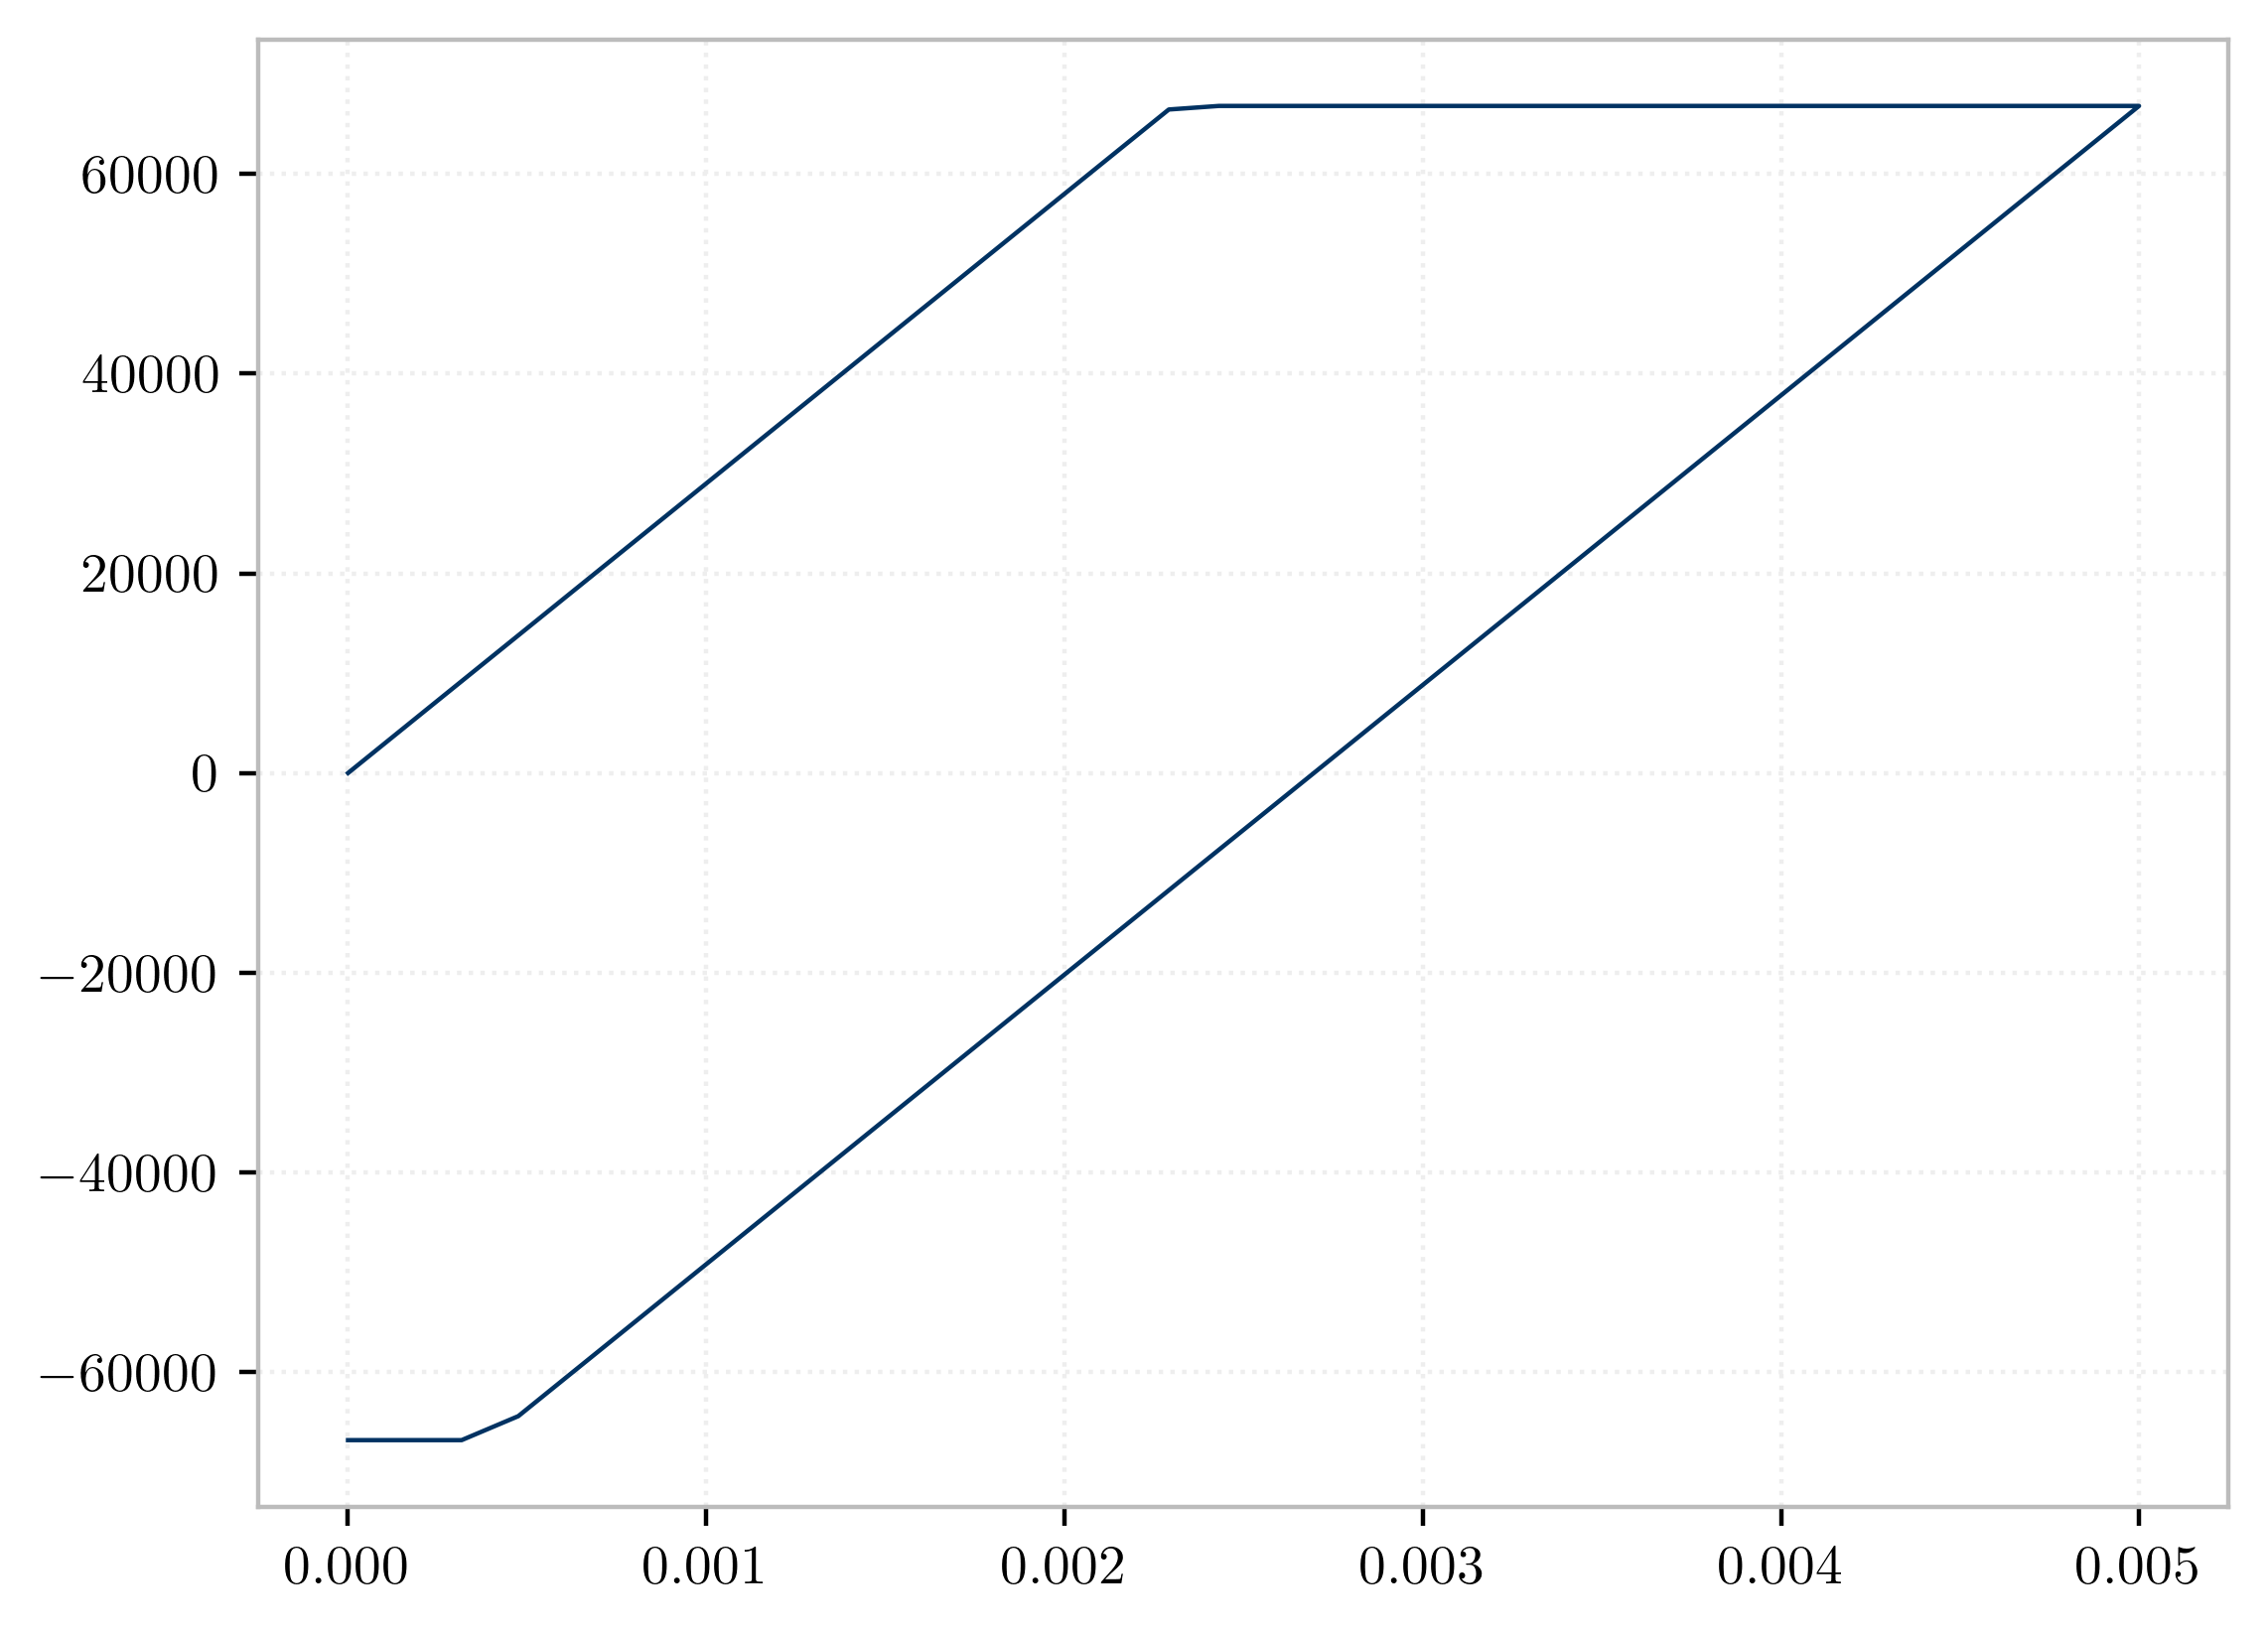

In [21]:
elastic_pp_material = uniaxial.ElasticPP(1, Es, Fy/Es)

strain = 0.005*sin(linspace(0, 1.0*pi, 100))


with elastic_pp_material as mat:
    stress_list = []
    for e in strain[:50] :
        stress_list.append(mat.getStress(e, commit=True))
        
    for e in strain[50:] :
        stress_list.append(mat.getStress(e, commit=False))

# create a plotting axis
fig, ax = plt.subplots()    
ax.plot(strain, stress_list, label="ElasticPP")

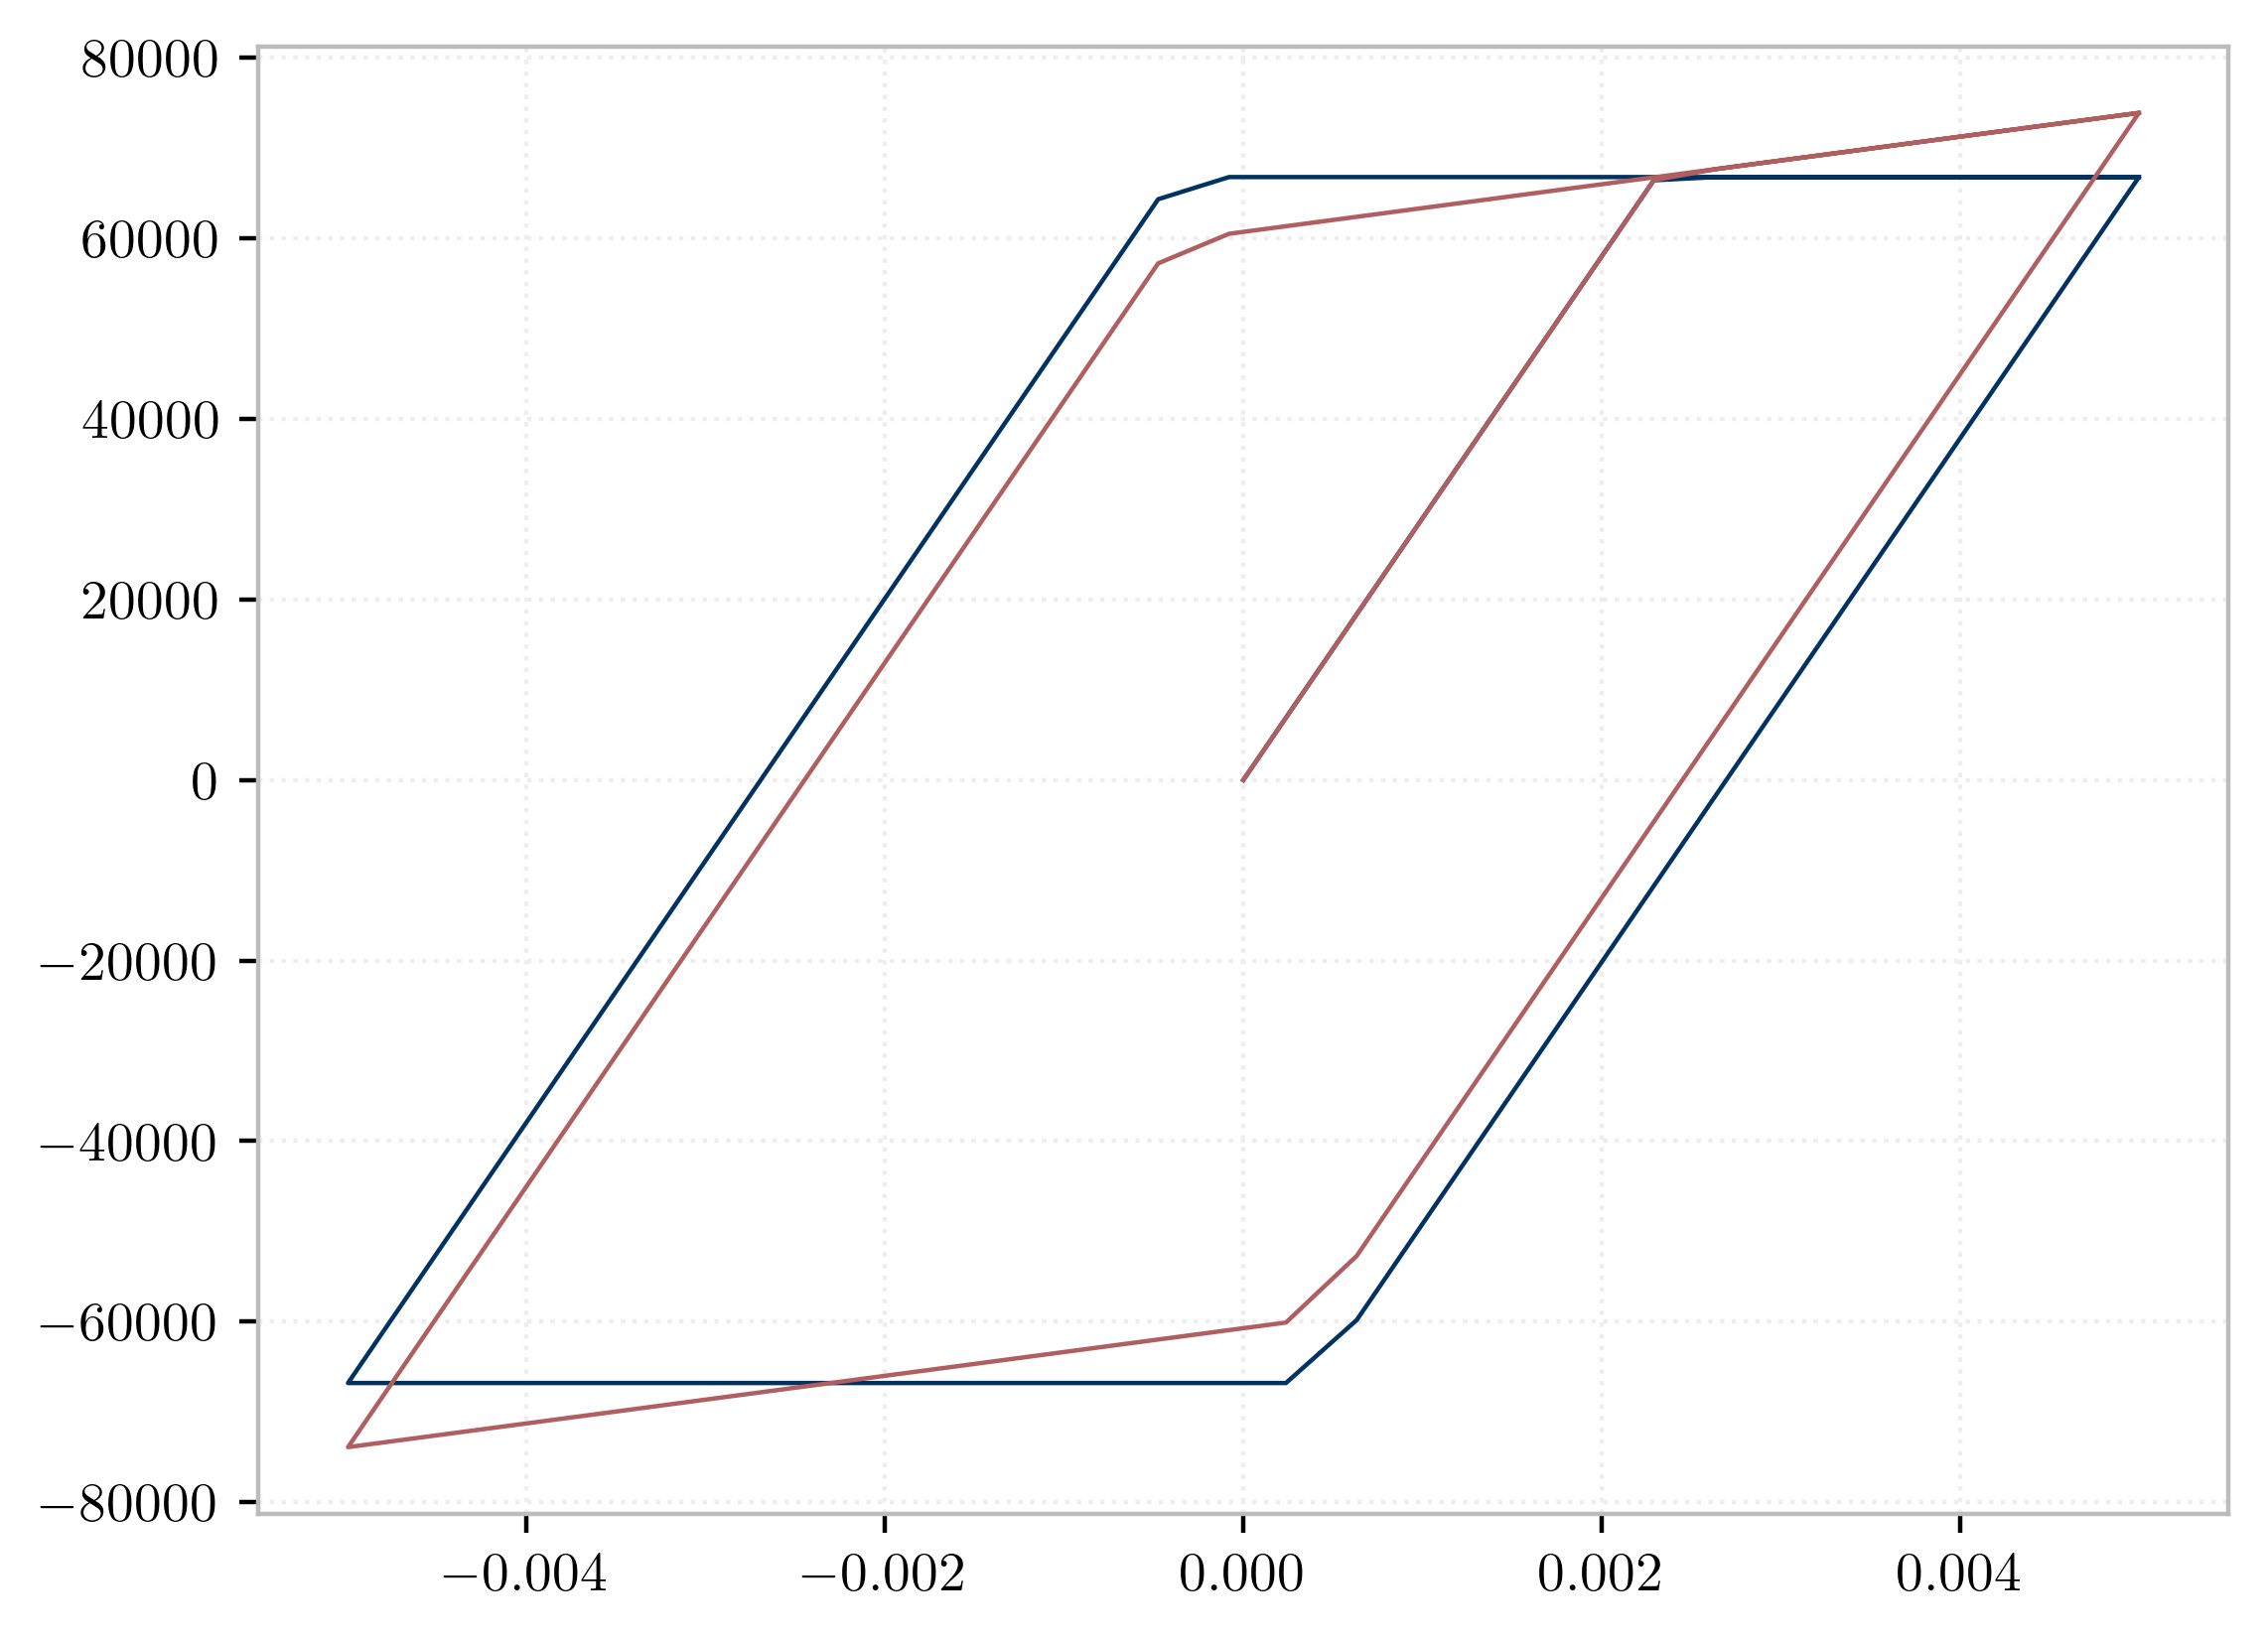

In [22]:
fig, ax = plt.subplots()

strain = 0.005*sin(linspace(0, 2.5*pi, 100))

with uniaxial.ElasticPP(1, Es, Fy/Es) as mat:
    stress = [mat.getStress(e, commit=True) for e in strain]
    ax.plot(strain, stress, label="ElasticPP")

with uniaxial.Hardening(1, Es, Fy, 0.0*Es, 0.1*Es) as mat:
    ax.plot(strain, [mat.getStress(e, commit=True) for e in strain], label="Hardening")


## Reinforcing Steel

The following features are typically desired of a reinforcing steel model:

- Bauschinger effect
- Low-cycle fatigue
- Buckling
- Hardening

In [23]:
Bs  = 0.005                # strain-hardening ratio 
R0  = 18                   # control the transition from elastic to plastic branches
cR1 = 0.925                # "
cR2 = 0.15                 # "

In [24]:
tangent = []

#                     no tag needed
steel = uniaxial.Steel02(None, Fy, Es, 0.05, R0=R0)


strain = 0.005*sin(linspace(0, 2.5*pi, 100))


with steel as mat:
    for e in strain:
        mat.setTrialStrain(e)
        Et = mat.getTangent()
        tangent.append(Et)
        mat.commitState()

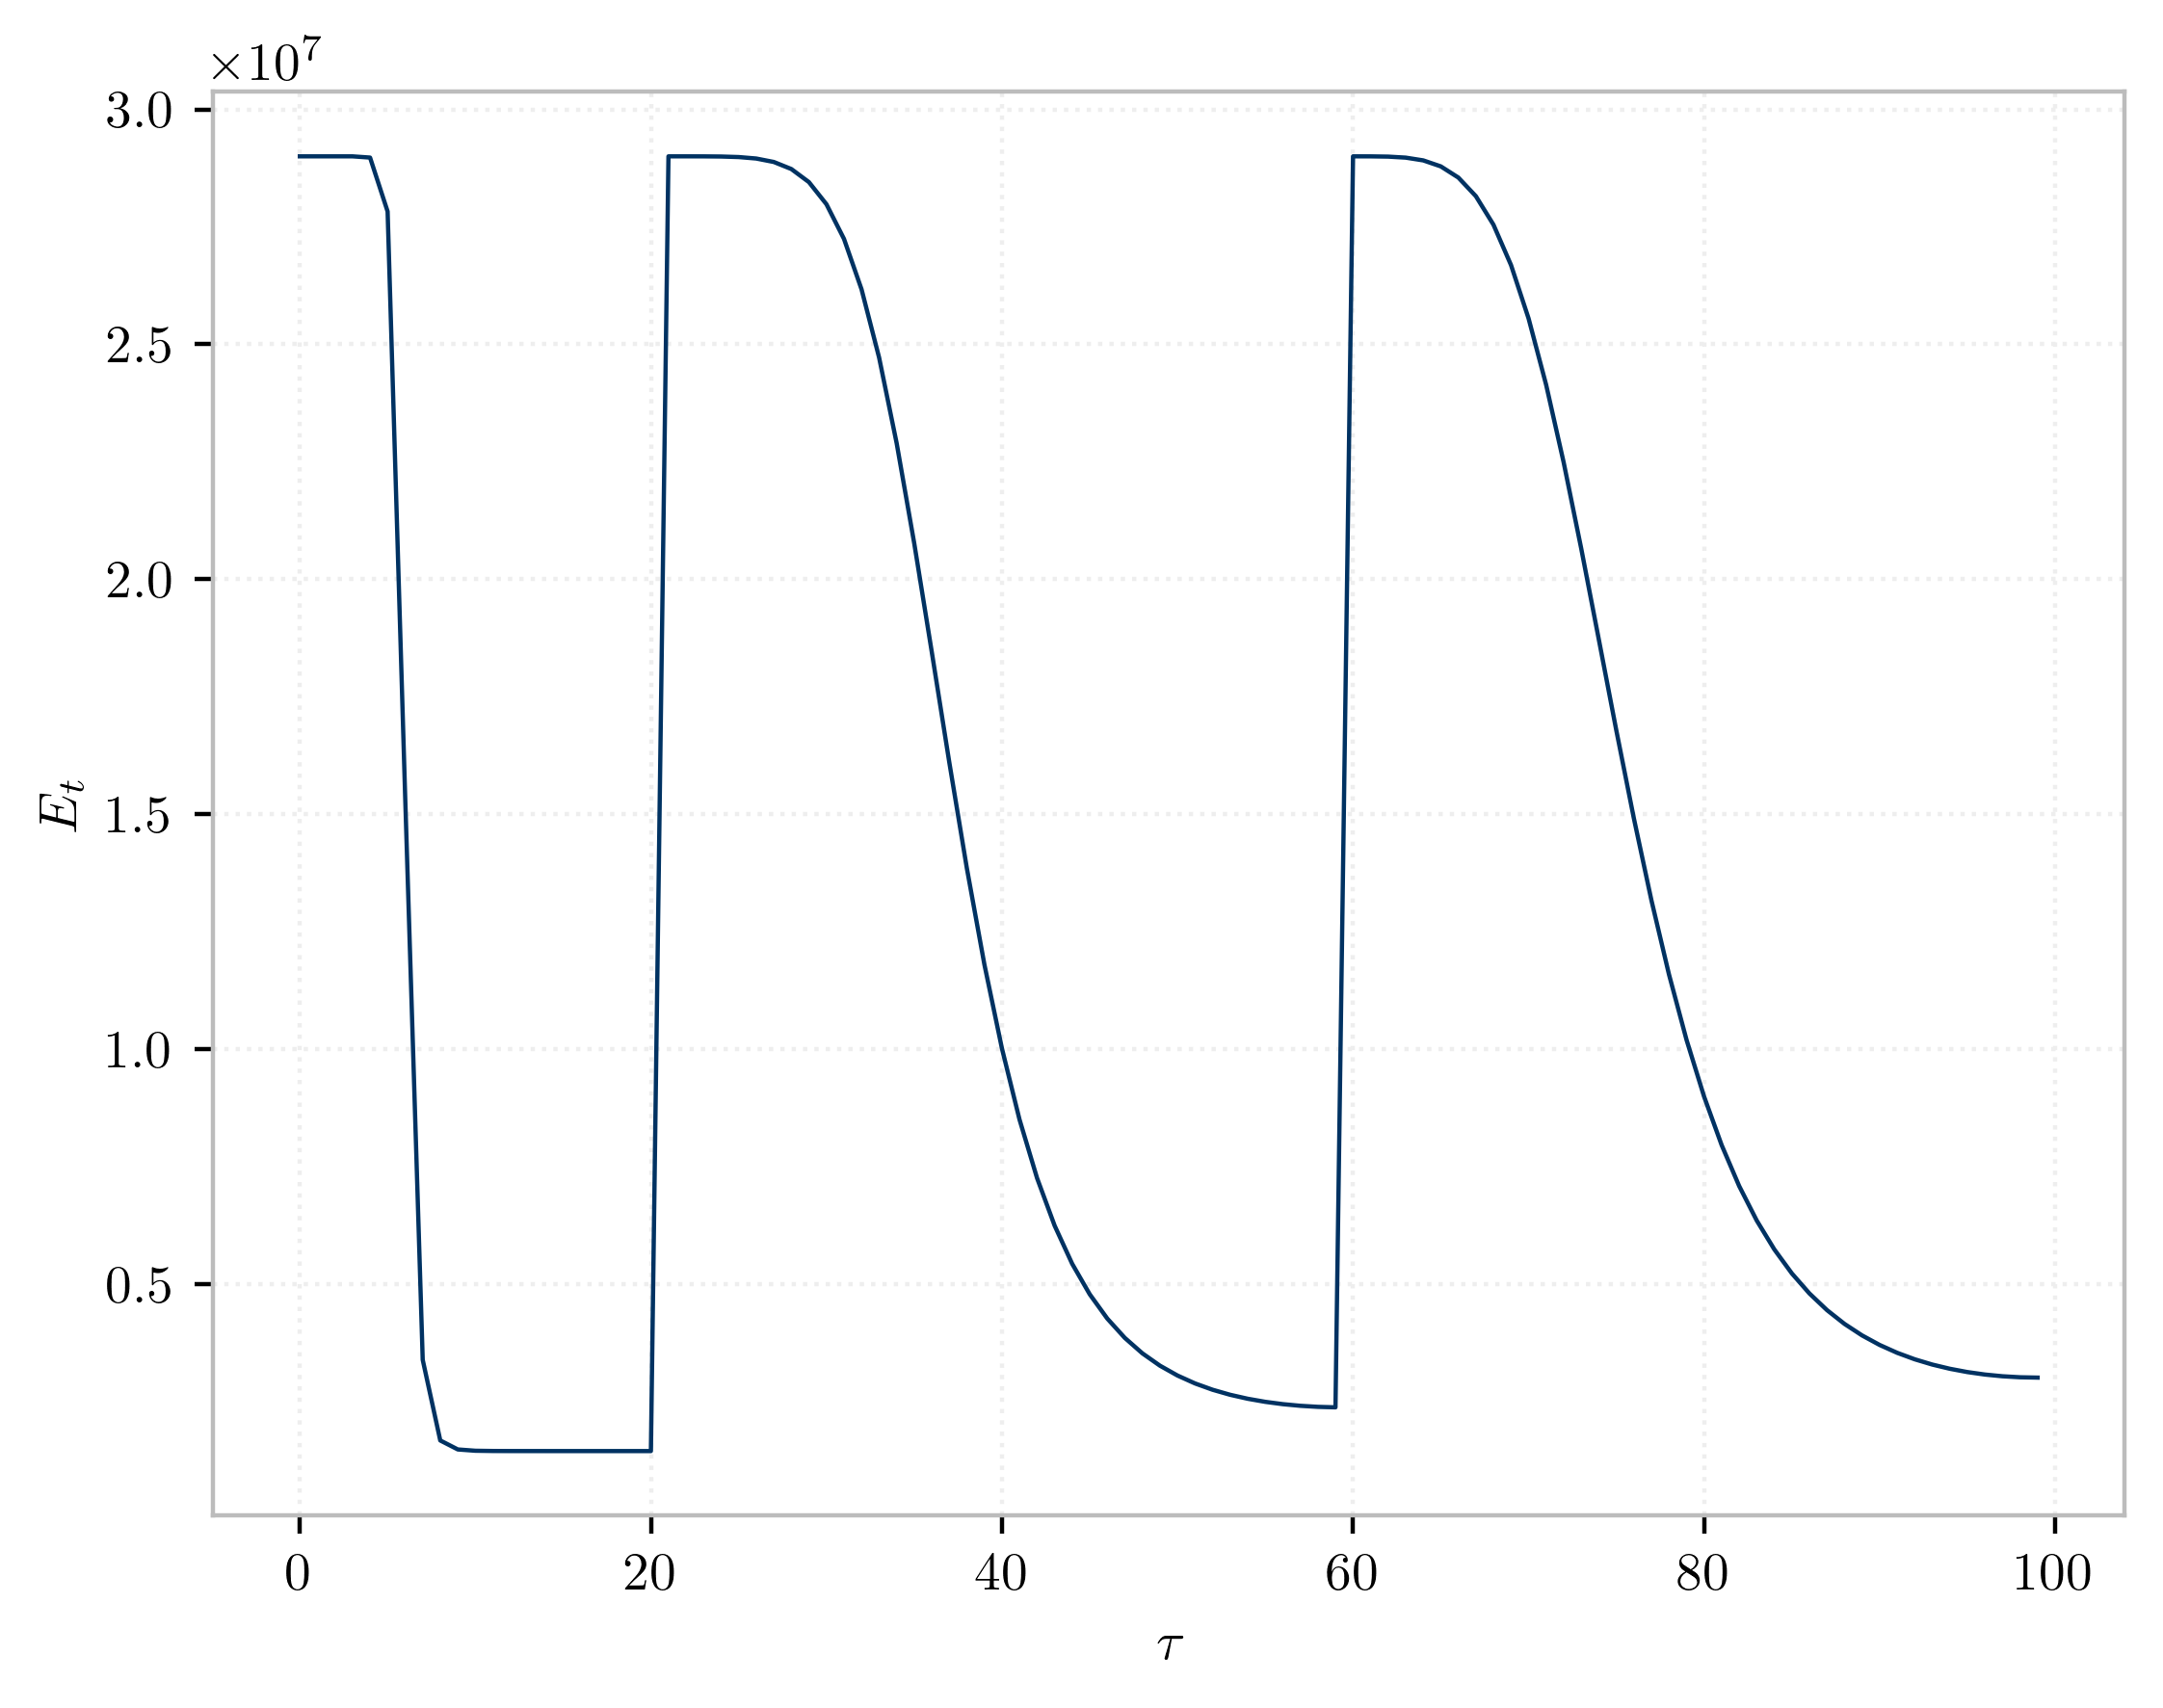

In [25]:
fig, ax = plt.subplots()
ax.plot(tangent)
ax.set_ylabel("$E_t$")
ax.set_xlabel(r"$\tau$");

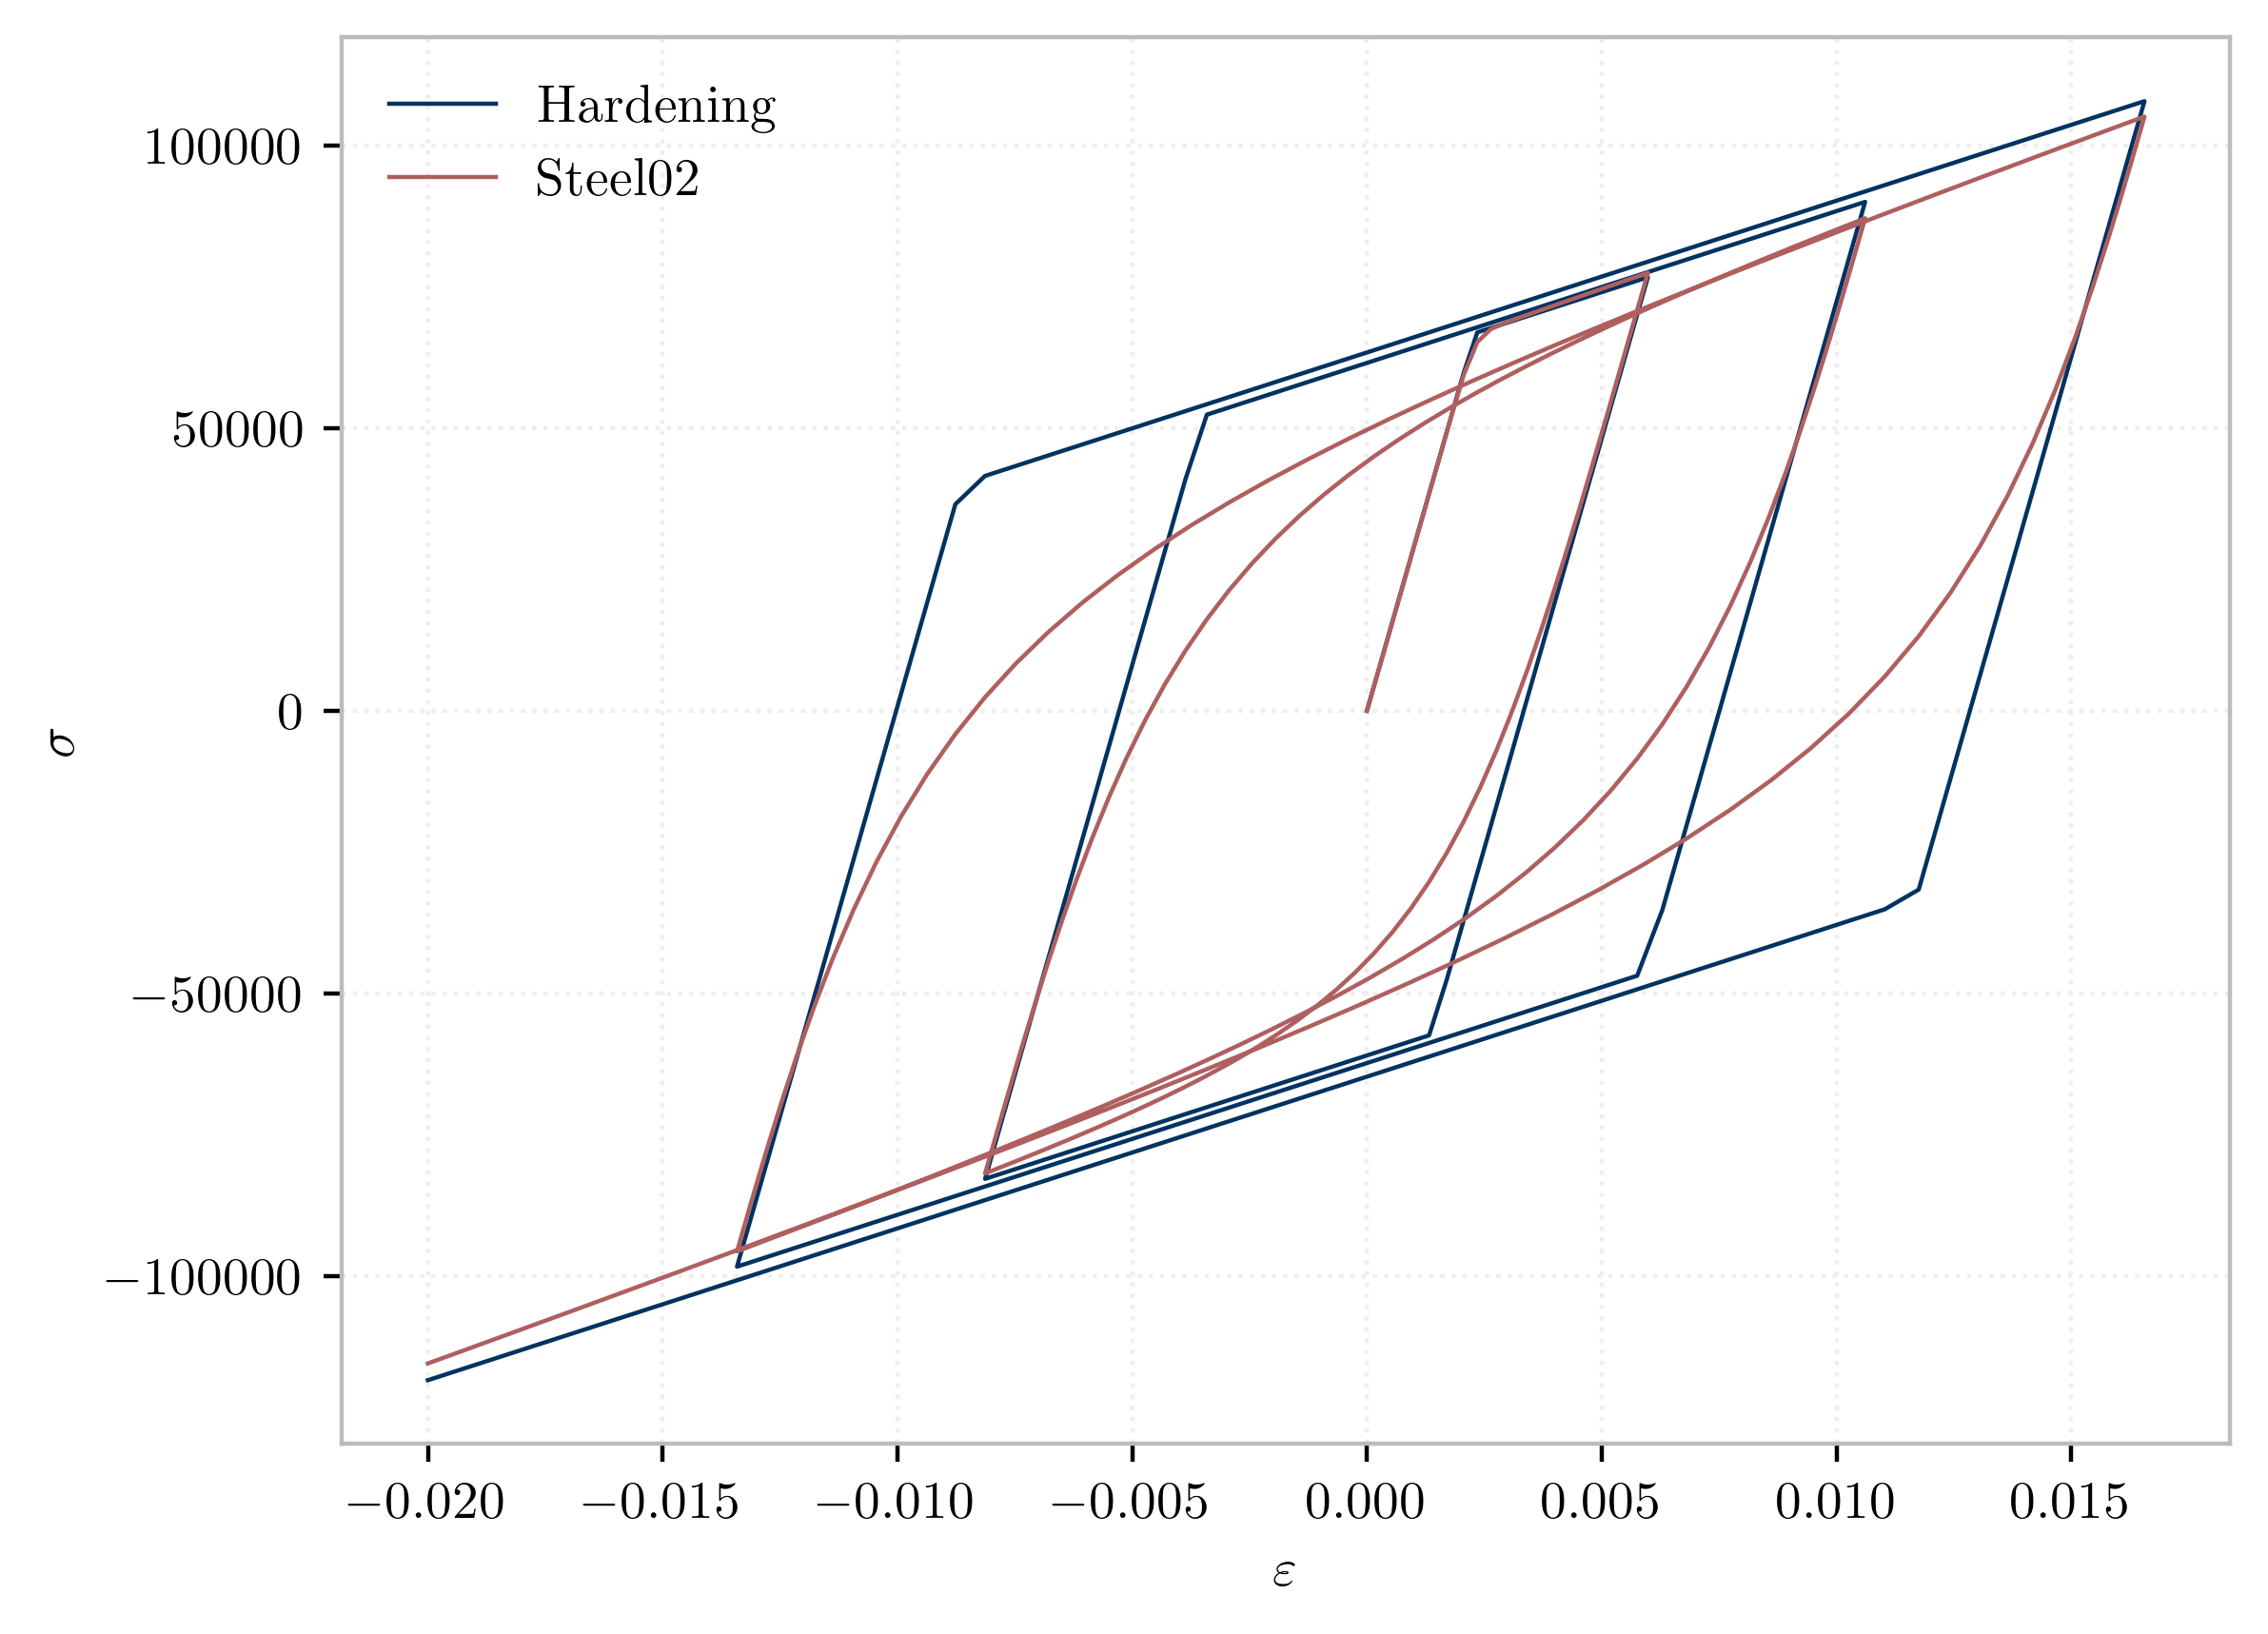

In [26]:
strain = 0.02*sin(linspace(0, 5.5*pi, 300))*linspace(0.5, 1, 300)**2

Bs = 0.1
fig, ax = plt.subplots()


with uniaxial.Hardening(None, Es, Fy, 0.002*Es, Bs*Es) as steel:
    ax.plot(strain, [steel.getStress(e, commit=True) for e in strain], label="Hardening")


with uniaxial.Steel02(None, Fy, Es, Bs, R0) as steel:
    ax.plot(strain, [steel.getStress(e, commit=True) for e in strain], label="Steel02")


with uniaxial.RambergOsgoodSteel(None, Fy, Es, 0.002, R0) as steel:
    ax.plot(strain, [steel.getStress(e, commit=True) for e in strain], label="RambergOsgoodSteel")


# esh, esu = 10*Fy/Es, 14*Fy/Es
# eshi = (esu + 5*esh)/5
# with uniaxial.DoddRestrepo(None, Fy, 1.2*Fy, esh, esu, Es, eshi, 1.1*Fy) as steel:
#     ax.plot(strain, [steel.getStress(e, commit=True) for e in strain], ":", label="DoddRestrepo")


# n = 11
# c = (Es/Fy)**(n)
# eta = [0.0*c, 1.*c]
# with uniaxial.BoucWen(None, Bs, 1., n, eta, [1, 0.0], [0.0, 0.0]) as m:
#     stress = [Es*m.getStress(e, commit=True) for e in strain]
#     ax.plot(strain, stress, "-.", label="BoucWen - GMP")

# eta = [0.5*c, 0.5*c]
# with uniaxial.BoucWen(None, Bs, 1., n, eta, [1, 0.0], [0.0, 0.0]) as m:
#     stress = [Es*m.getStress(e, commit=True) for e in strain]
#     ax.plot(strain, stress, "-.", label="BoucWen - Plastic")
    
# uniaxial.Bond_SP01(1, Fy, Sy=1.0, Fu=1.4*Fy, Su=, b=, R=)

ax.set_xlabel(r"$\varepsilon$")
ax.set_ylabel(r"$\sigma$")
ax.legend();

## Concrete

In [27]:
# nominal concrete compressive strength
fc = -8.5*ksi              # Concrete compressive strength ksi   (+Tension -Compression)
Ec = 57*ksi*sqrt(-fc/psi)  # Concrete Elastic Modulus

# unconfined concrete
fc1U = fc                  # unconfined concrete (todeschini parabolic model) maximum stress
eps1U = -0.003             # strain at maximum strength of unconfined concrete
fc2U = 0.2*fc1U            # ultimate stress
eps2U = -0.01              # strain at ultimate stress
_lambda = 0.1              # ratio between unloading slope at eps2 and initial slope Ec

# tensile-strength properties
ftU = -0.14*fc1U           # tensile strength +tension
Ets = ftU/0.002            # tension softening stiffness

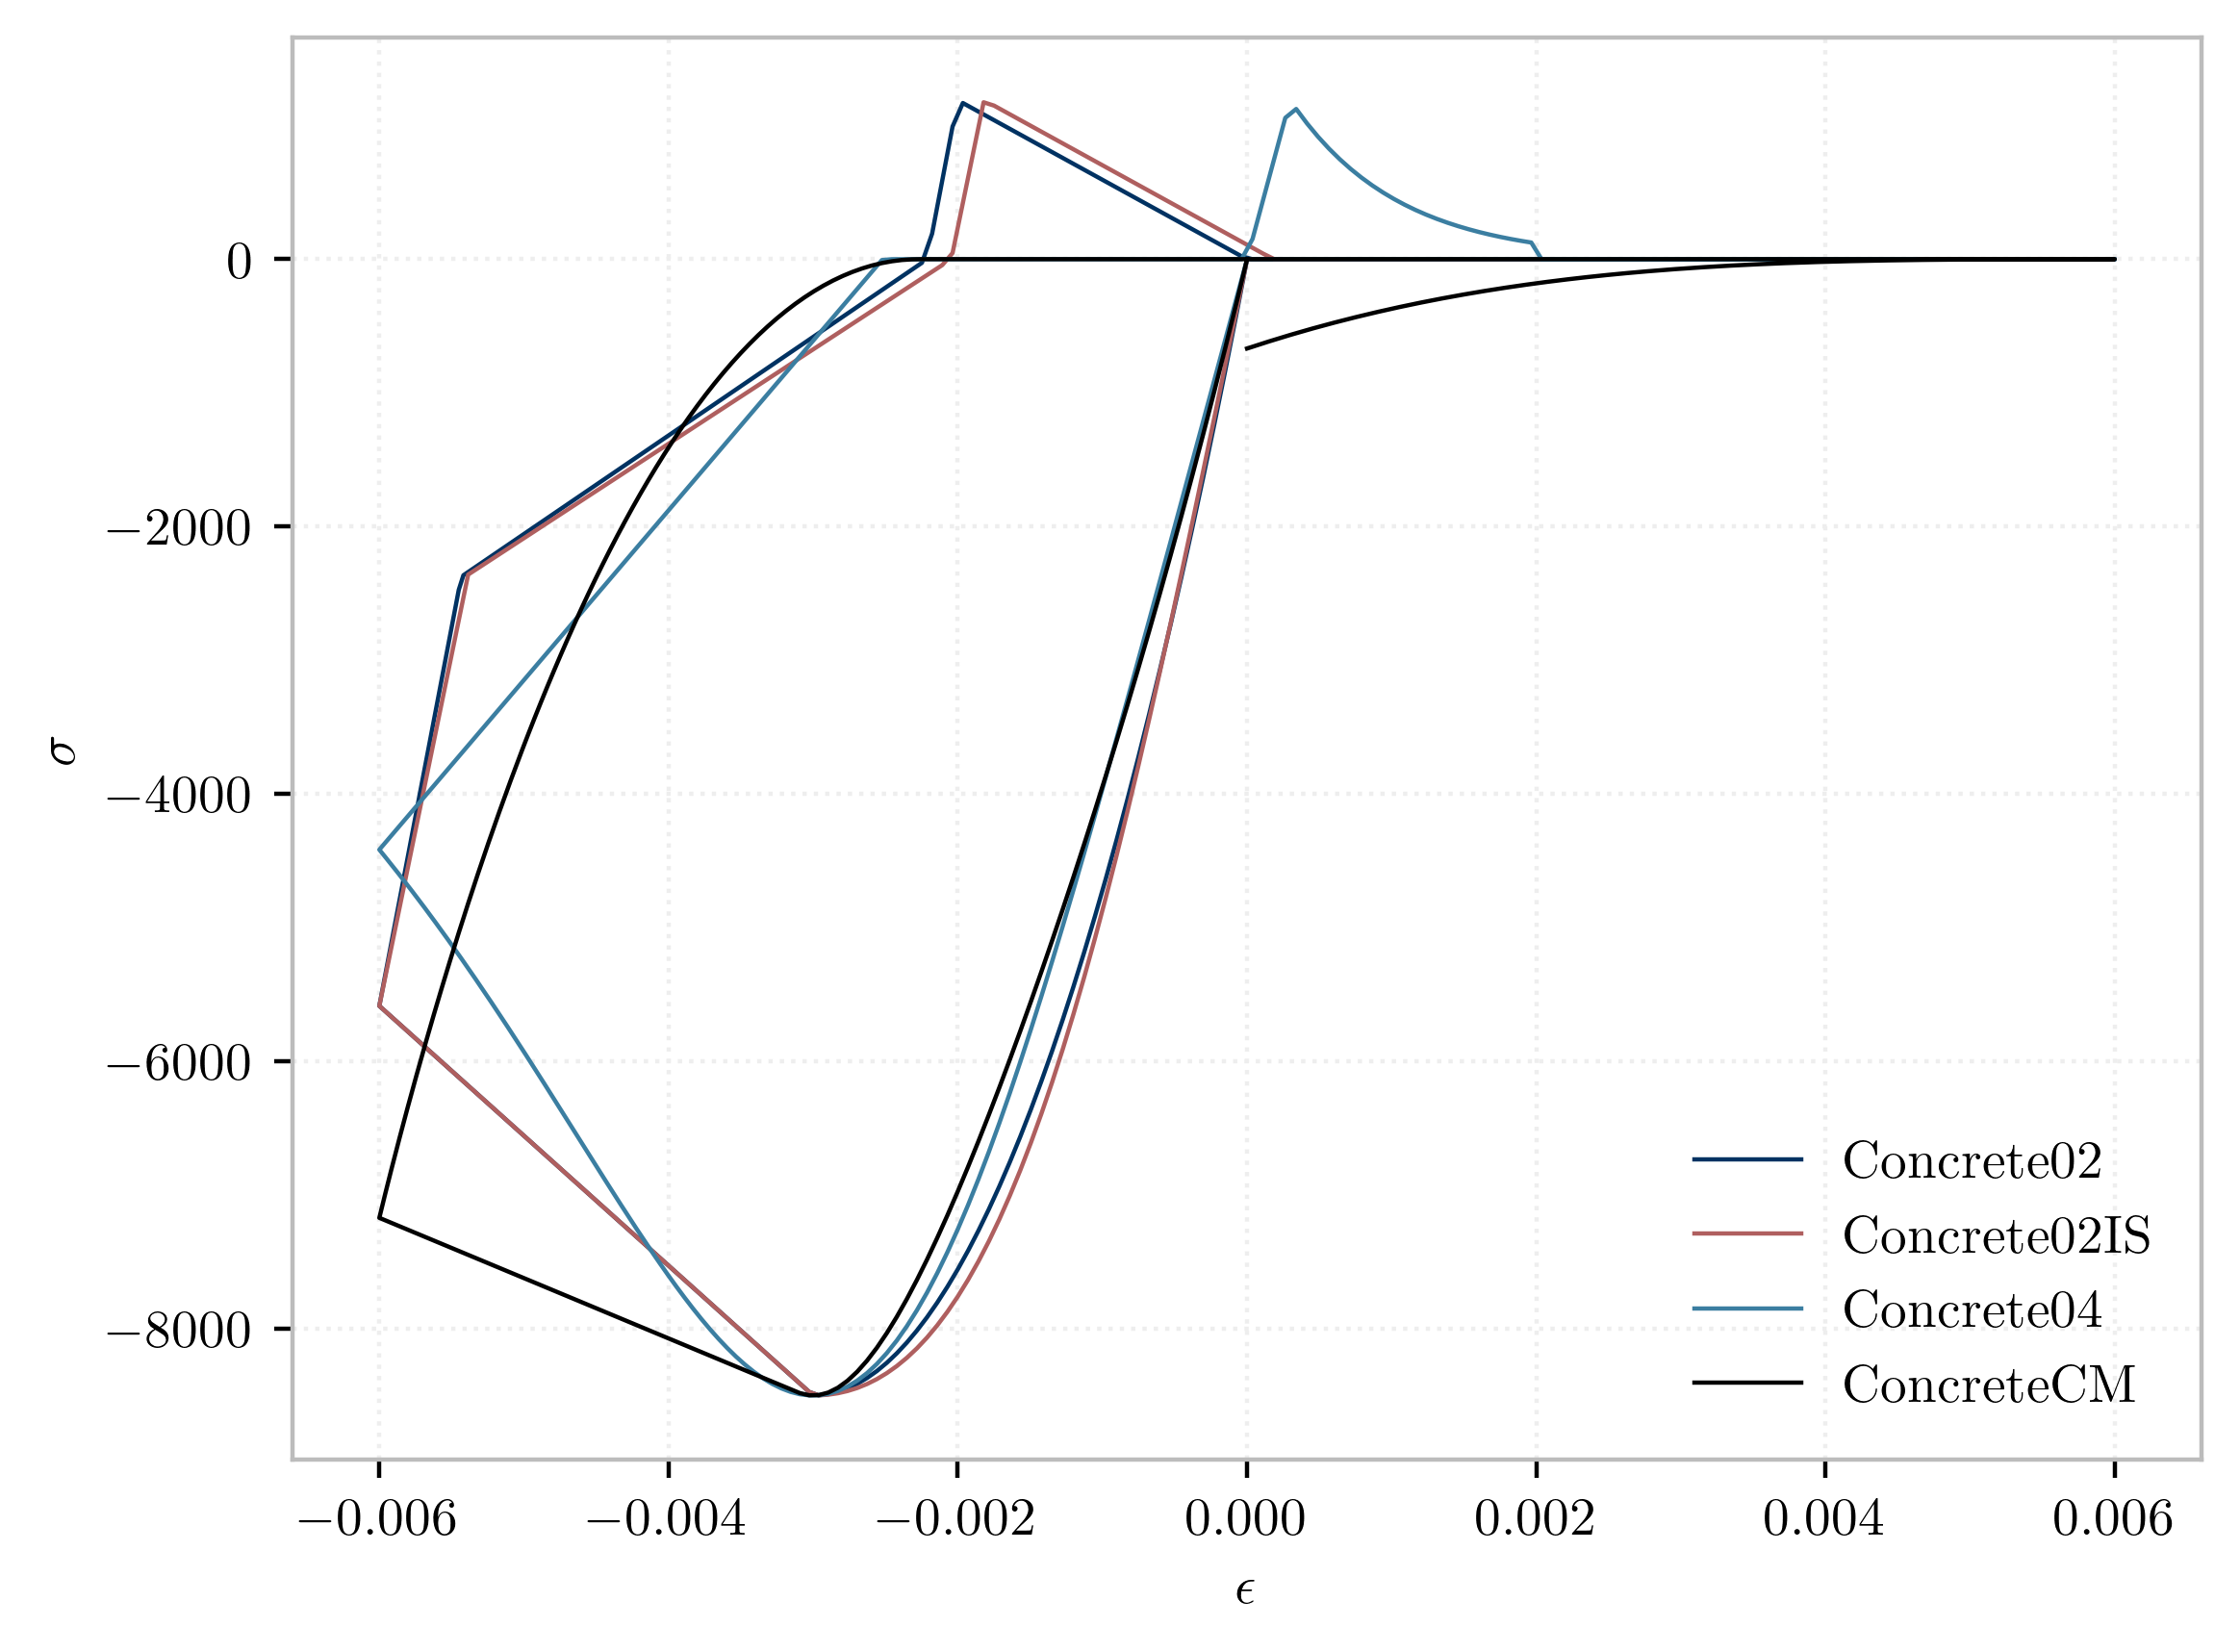

In [28]:
strain  = -0.006*sin(linspace(0, 2*pi, 500))
fig, ax = plt.subplots()

with uniaxial.Concrete02(1, fc1U, eps1U, fc2U, eps2U, _lambda, ftU, Ets) as c:
    ax.plot(strain, [c.getStress(e, commit=True) for e in strain], label="Concrete02")
    
with uniaxial.Concrete02IS(1, Ec, fc1U, eps1U, fc2U, eps2U, [_lambda, ftU, Ets]) as conc:
    ax.plot(strain, [conc.getStress(e, commit=True) for e in strain], label="Concrete02IS")

with uniaxial.Concrete04(1, fc1U, eps1U, eps2U, 4e3*ksi, [ftU, ftU/Ets]) as conc:
    ax.plot(strain, [conc.getStress(e, commit=True) for e in strain], label="Concrete04")

with uniaxial.ConcreteCM( 1, fc1U, eps1U, 4500*ksi, 7, 1.035, 0.30, 0.00008, 1.2, 10000) as conc:
    ax.plot(strain, [conc.getStress(e, commit=True) for e in strain], label="ConcreteCM")

ax.legend()
ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"$\sigma$");

In [29]:
strain = 0.02*sin(linspace(0, 5.5*pi, 300))*linspace(0.5, 1, 300)**2

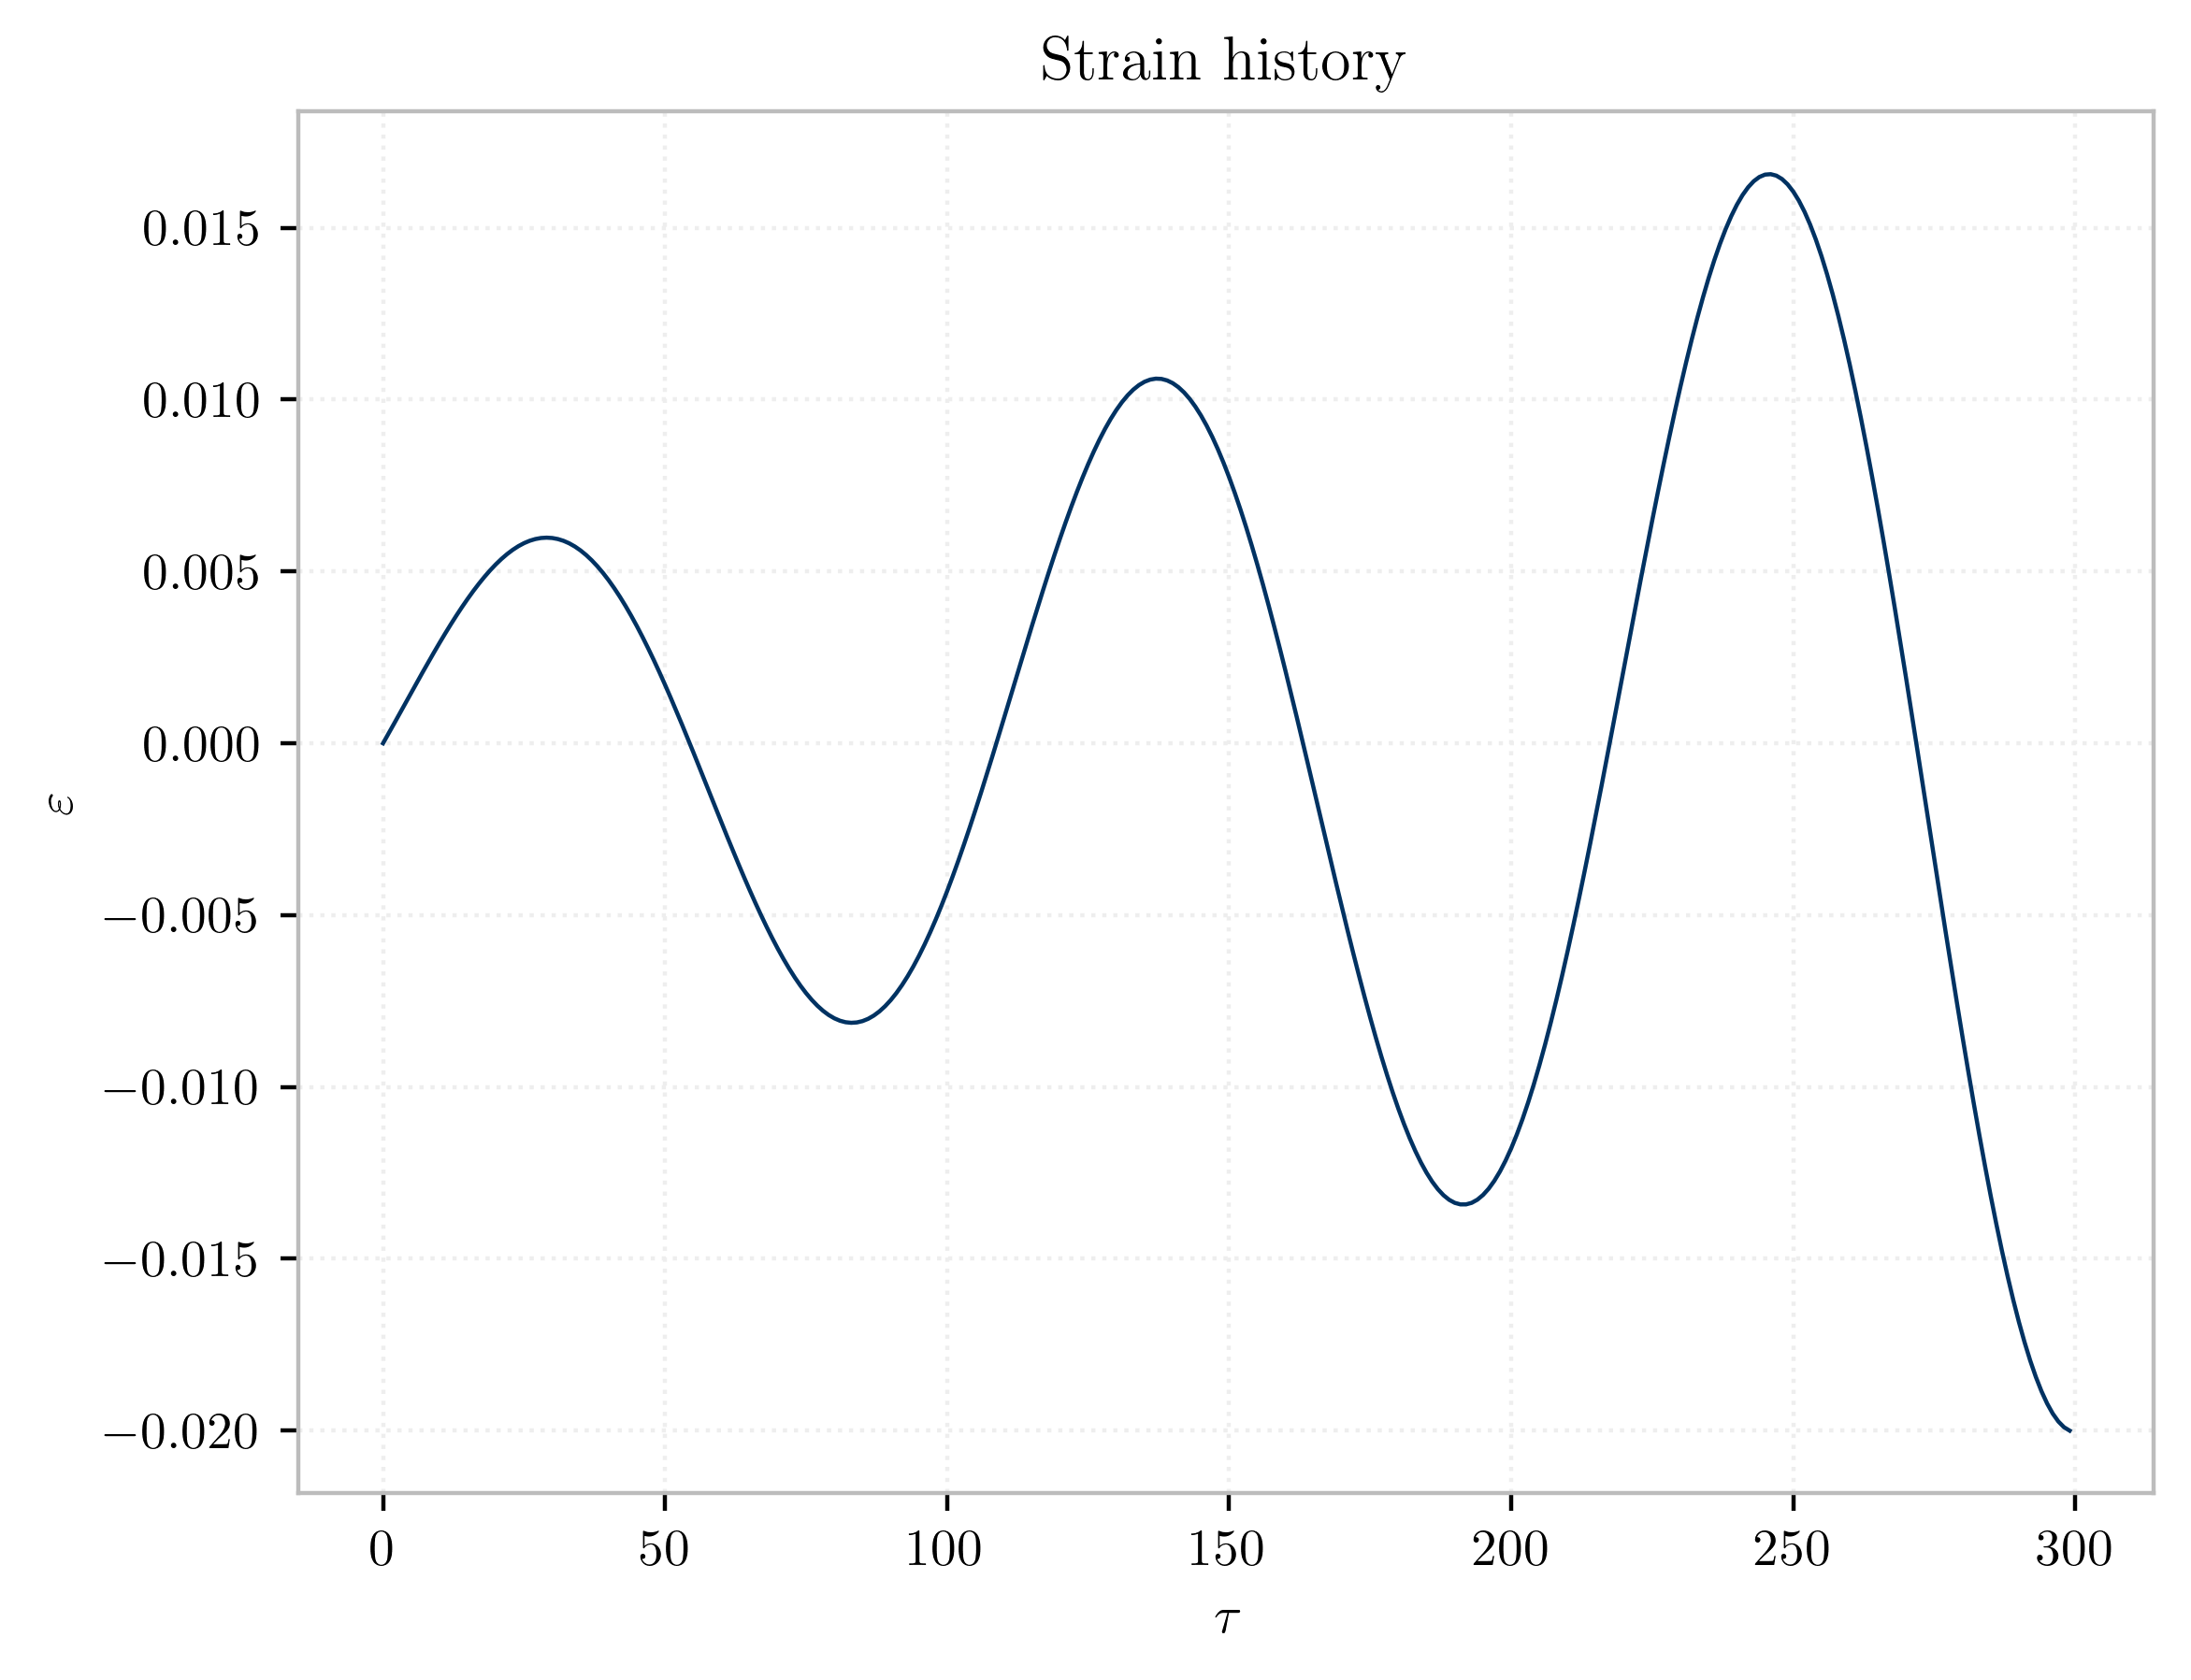

In [12]:
fig, ax = plt.subplots()
ax.plot(strain)
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$\varepsilon$")
ax.set_title("Strain history");

## Parallel Composition

### Bilinear Flag

In [30]:
mat_a = uniaxial.Hardening(1, 15e3, fy=15., H_iso=0., H_kin=5e1)
mat_b = uniaxial.ElasticBilin(2, 45e3, 1e2, 15/15e3)

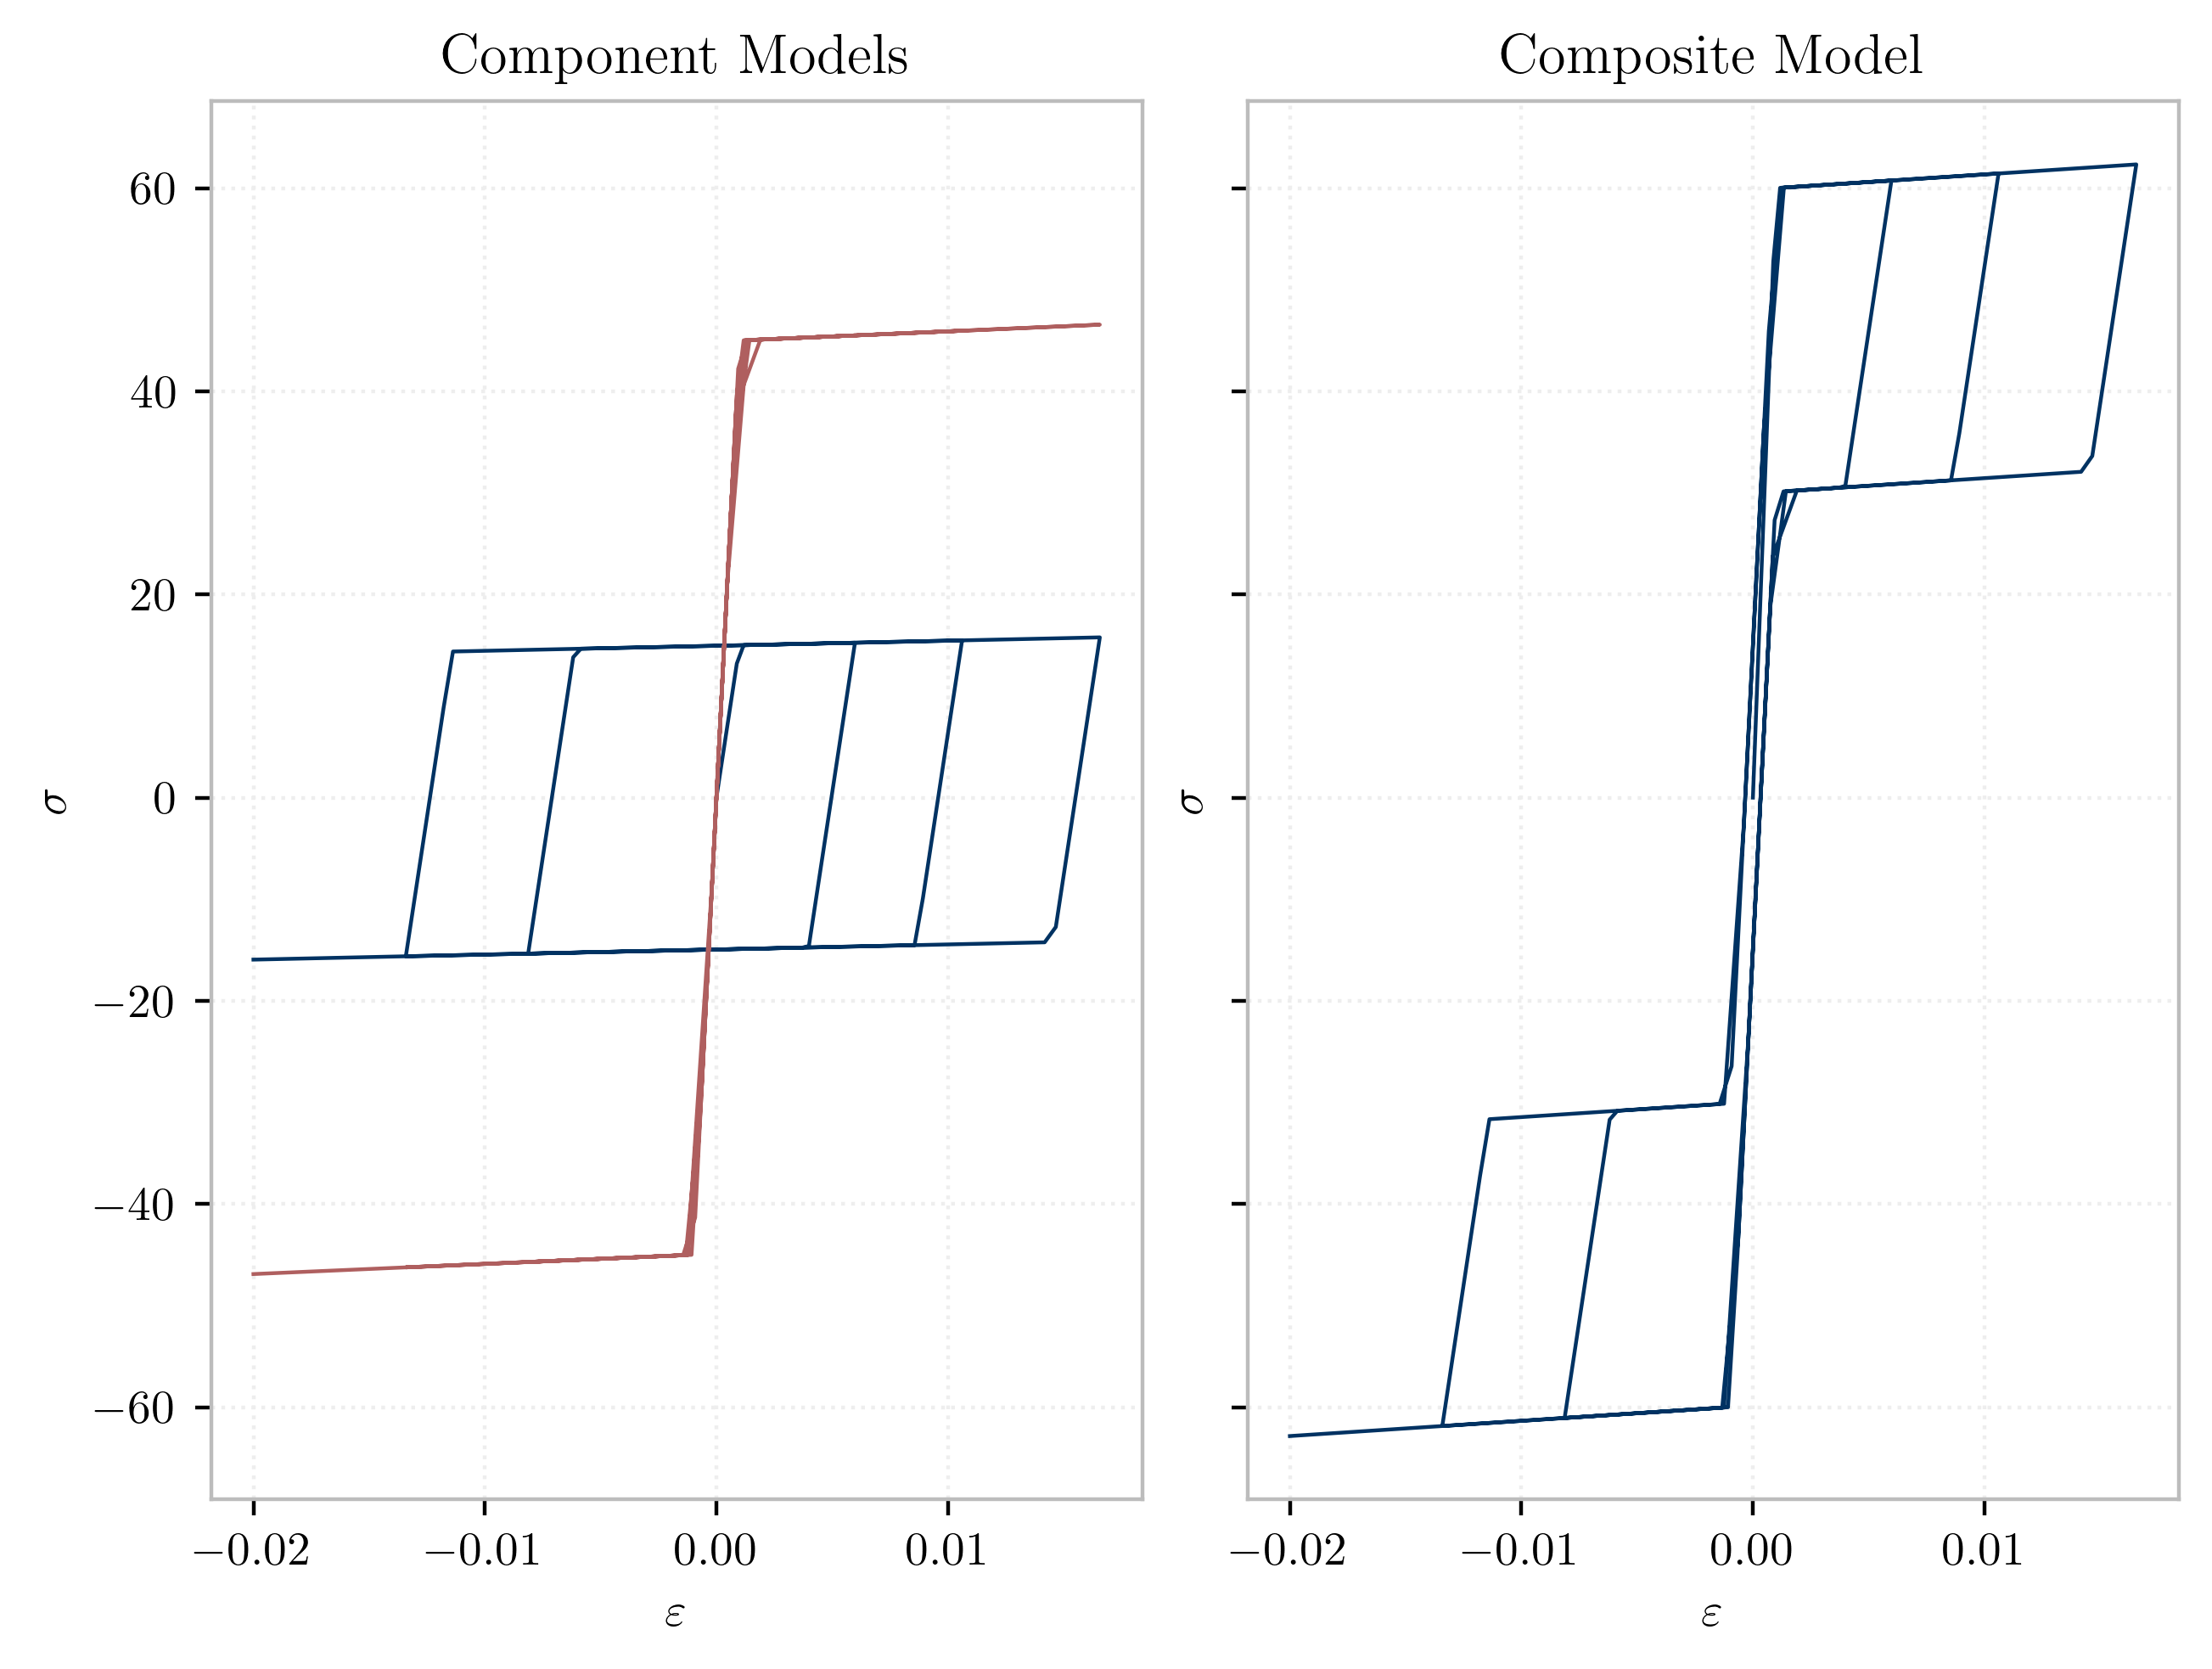

In [31]:
fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True)

with mat_a as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])

with mat_b as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])


# with mat_a as m:
#     ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])
with uniaxial.Parallel(3, [mat_a, mat_b]) as m:
    ax[1].plot(strain, [m.getStress(e, commit=True) for e in strain])


ax[0].set_title("Component Models")
ax[1].set_title("Composite Model")
for a in ax:
    a.set_xlabel(r"$\varepsilon$");
    a.set_ylabel(r"$\sigma$");

## Series Composition

### Brittle Fracture

### Trilinear Response

In [32]:
mat_a = uniaxial.Hardening(None, 40e3, fy=40., H_iso=0., H_kin=5e3)
mat_b = uniaxial.Hardening(None, 30e3, fy=60., H_iso=0., H_kin=5e2)

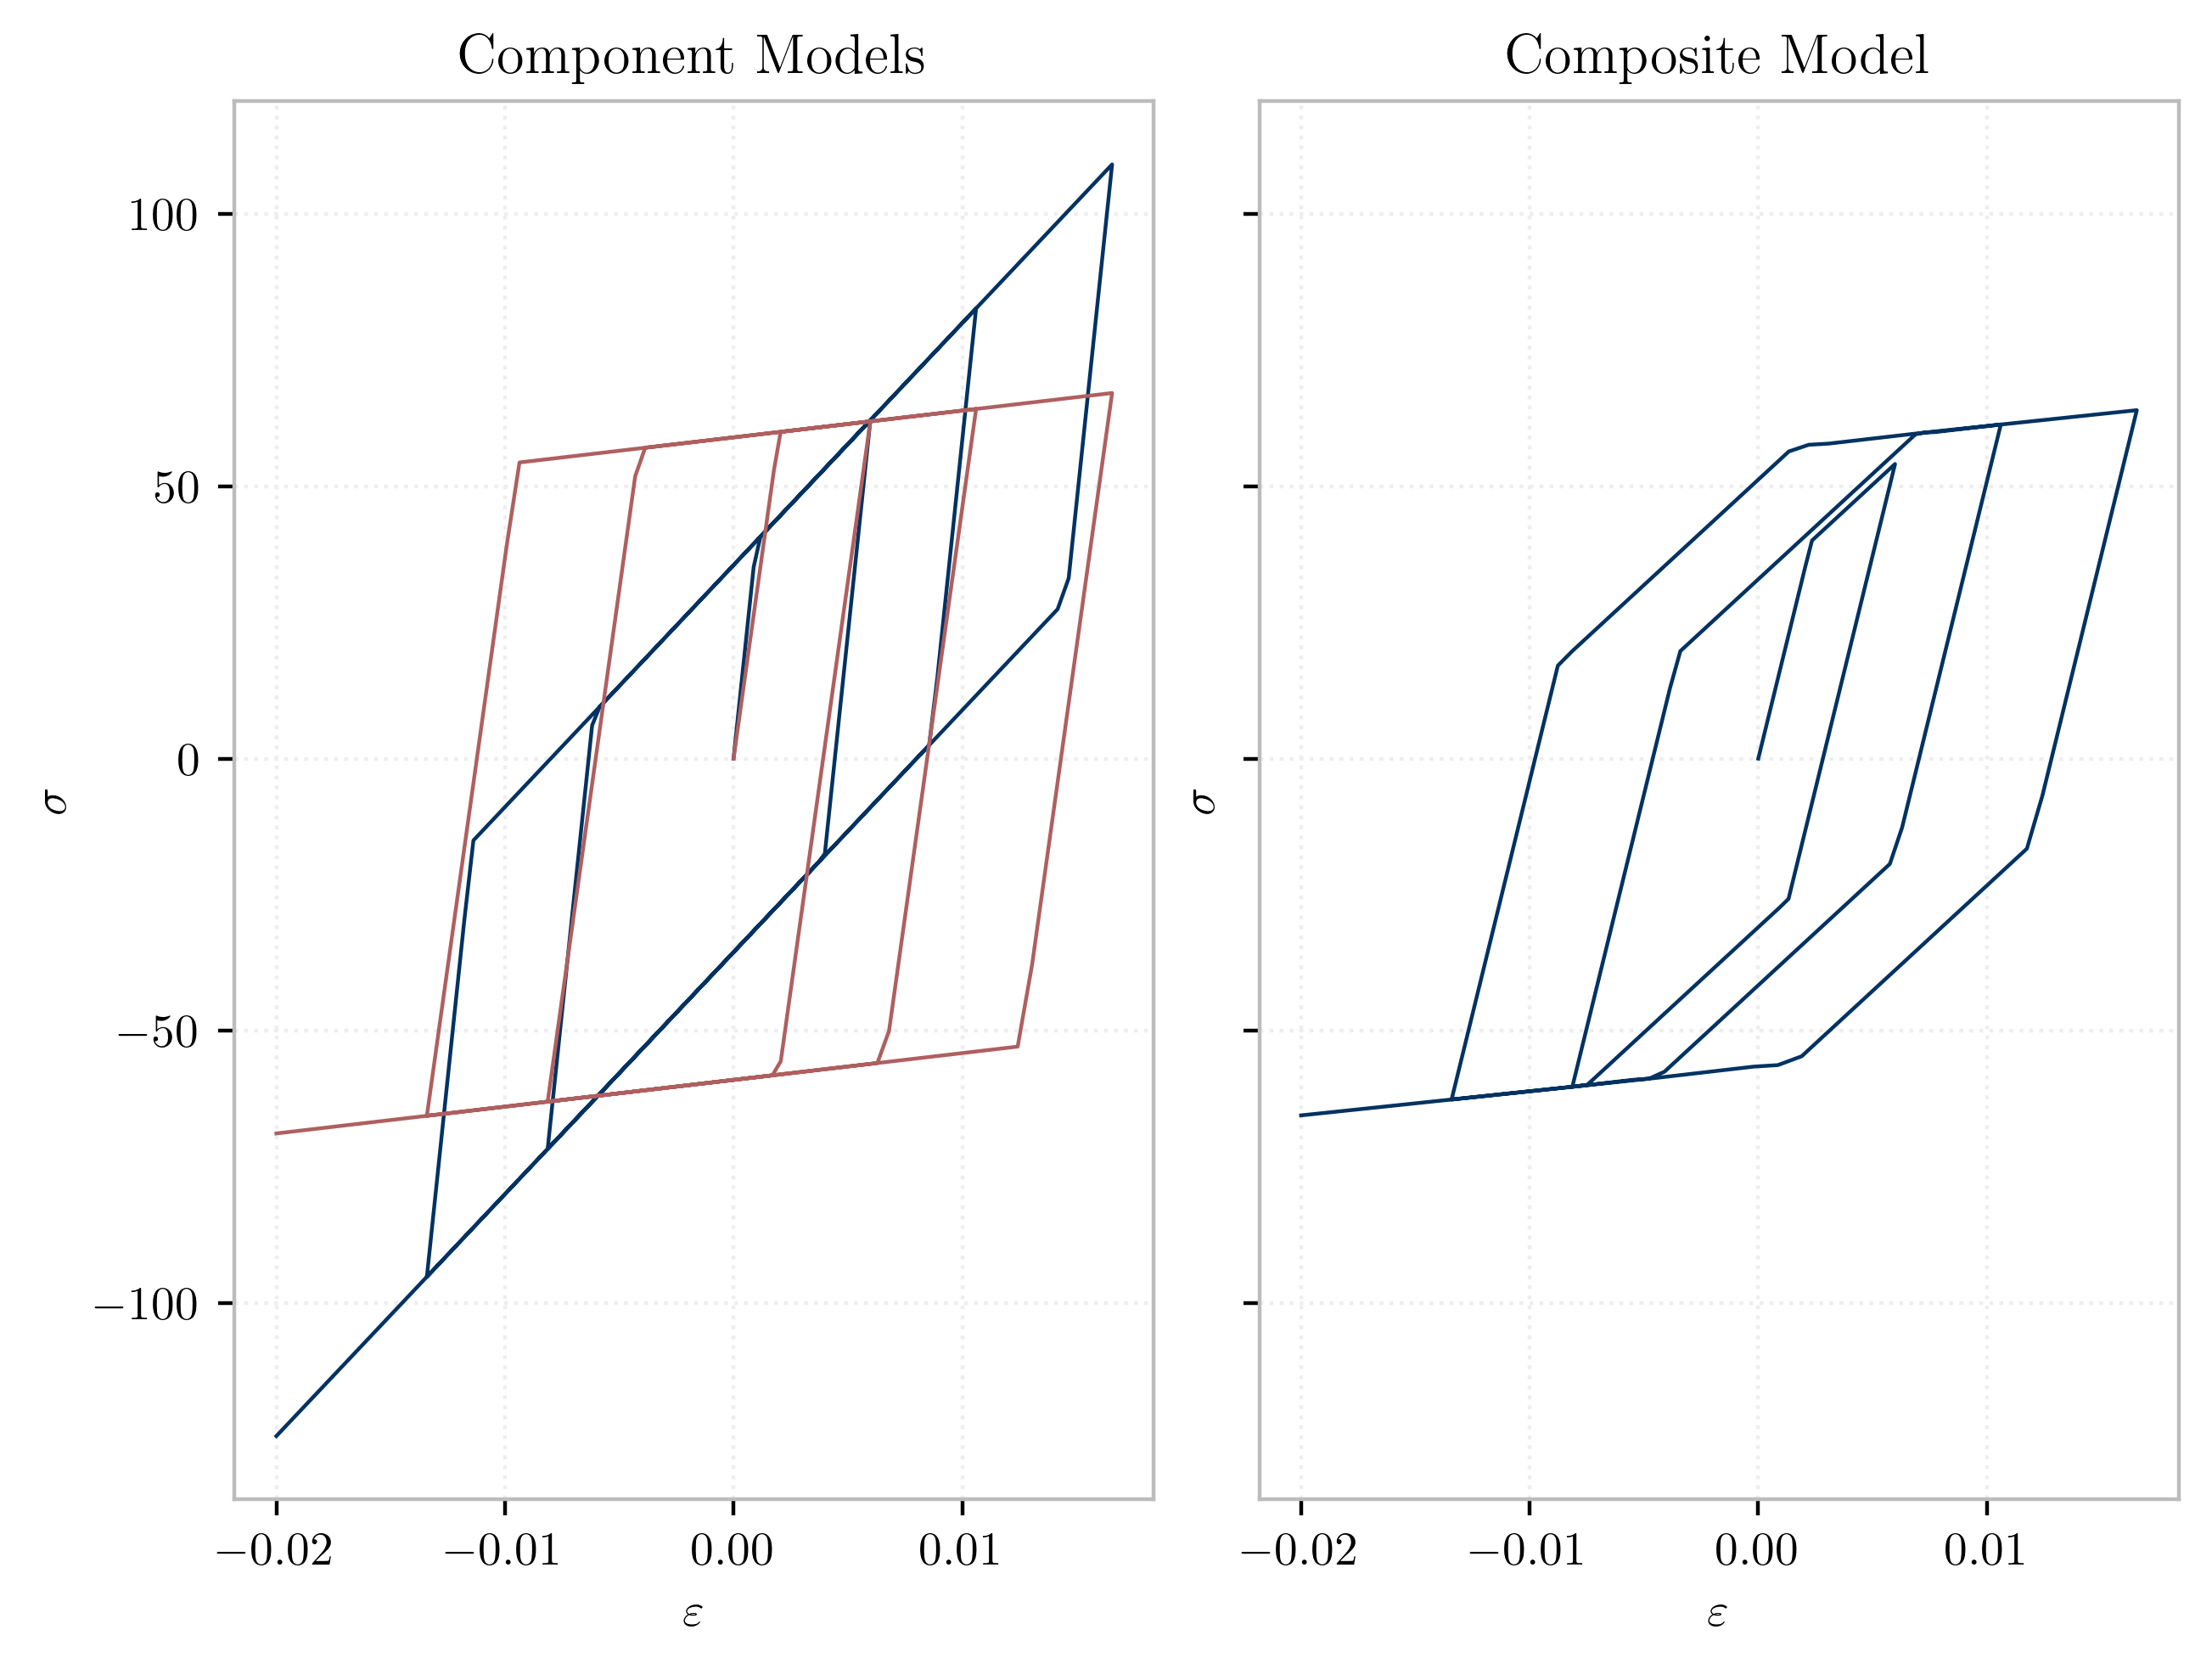

In [33]:
fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True)

with mat_a as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])
    
with mat_b as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])
    
with uniaxial.Series(3, [mat_a, mat_b]) as m:
    ax[1].plot(strain, [m.getStress(e, commit=True) for e in strain])

    
ax[0].set_title("Component Models")
ax[1].set_title("Composite Model")
for a in ax:
    a.set_xlabel(r"$\varepsilon$");
    a.set_ylabel(r"$\sigma$");

### Slipping

In [34]:
mat_a = uniaxial.Hardening(None, 30e3, fy=60., H_iso=0., H_kin=1e2)
mat_b = uniaxial.ElasticBilin(None, 10.0, 30e3, 0.01)

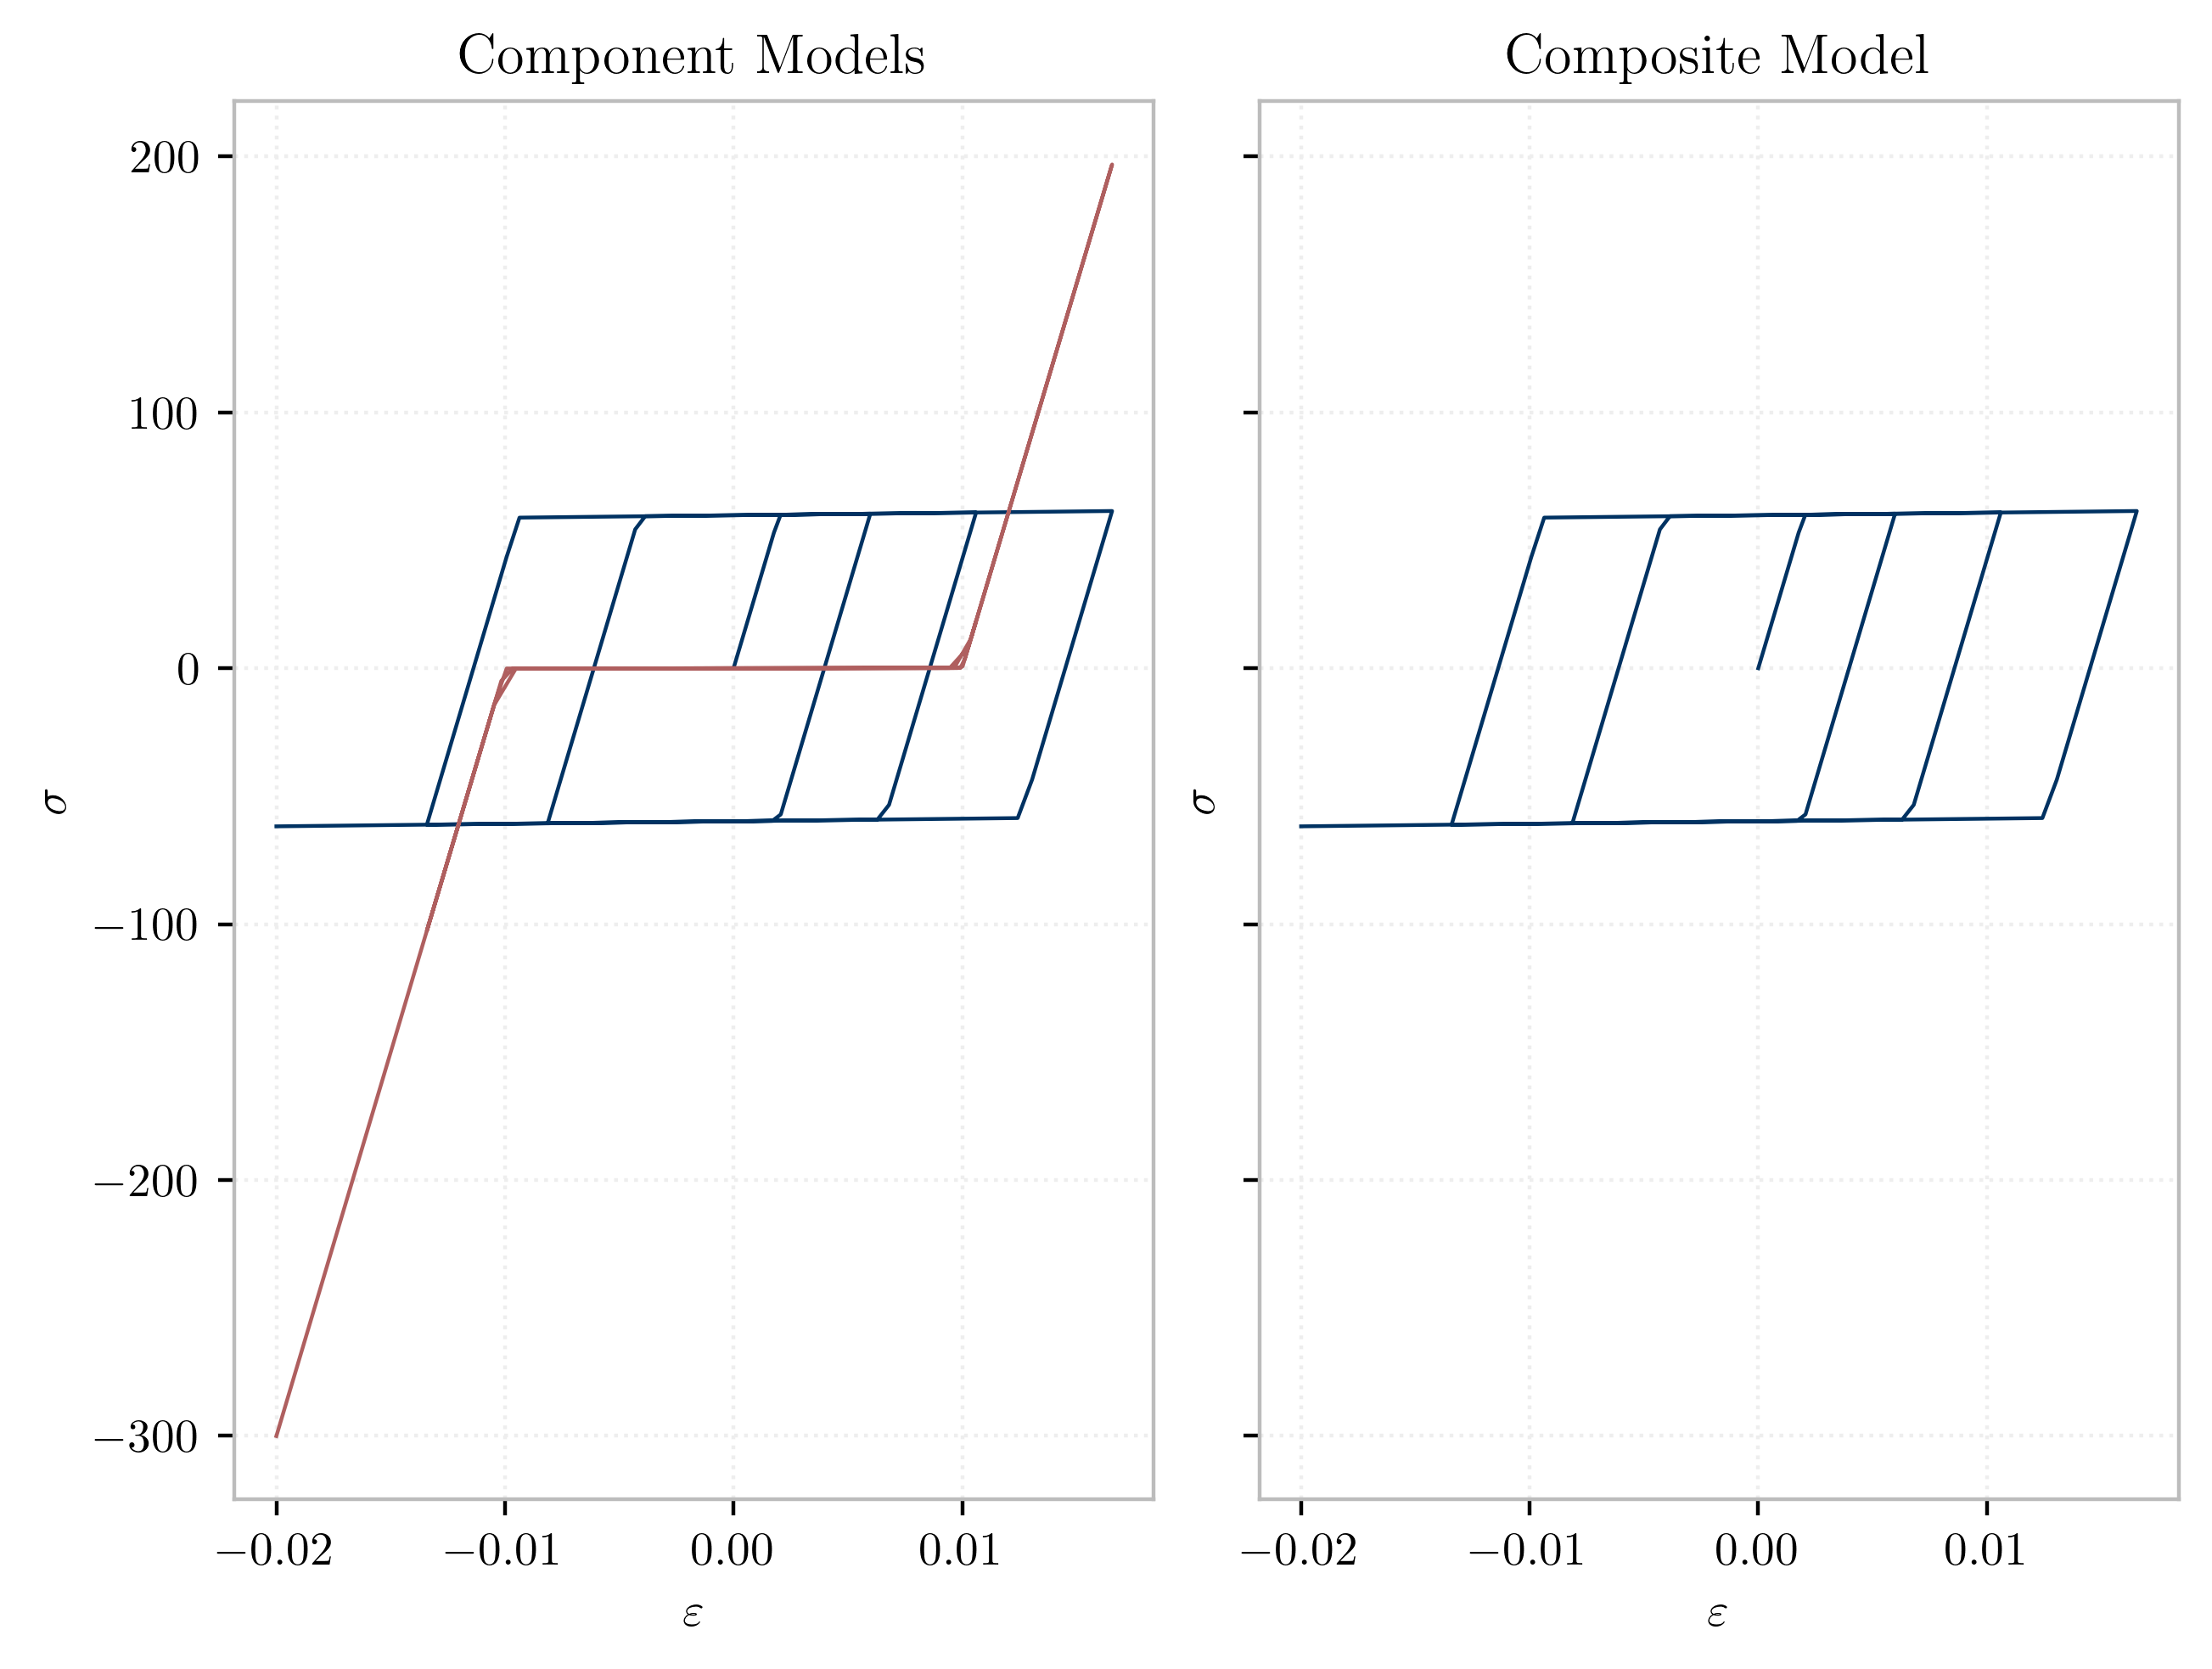

In [35]:
fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True)

with mat_a as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])
    
with mat_b as m:
    ax[0].plot(strain, [m.getStress(e, commit=True) for e in strain])

with uniaxial.Series(None, [mat_a, mat_b]) as m:
    ax[1].plot(strain, [m.getStress(e, commit=True) for e in strain])


ax[0].set_title("Component Models")
ax[1].set_title("Composite Model")
for a in ax:
    a.set_xlabel(r"$\varepsilon$");
    a.set_ylabel(r"$\sigma$");